# Classic Deep Learning 
Repository: https://github.com/ZainK-hub/satbinclass

This notebook uses the versions listed below of the following packages:
* Python: 3.7.4
* PANDAS: 0.25.1
* Numpy: 1.17.2
* Matplotlib: 3.1.1
* Scikit-learn: 0.21.3
* Scipy: 1.3.1
* Tensorflow-GPU 1.14.0
* Tensorflow 1.14.0
* CUDA toolkit: 10.1.168
* CUDNN: 7.6.0
* Keras-GPU: 2.2.4
* Keras-preprocessing: 1.1.0

In [1]:
#Seed random generators to ensure reproducible results
from numpy.random import seed
seed(7)
from tensorflow import set_random_seed 
set_random_seed(7)
from math import ceil
import efficientnet.keras as efn
from efficientnet.keras import center_crop_and_resize #, preprocess_input

import time
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from keras.utils import np_utils, to_categorical, plot_model
from keras.applications import imagenet_utils, resnet50, resnet
from keras.applications import resnext
from keras.applications.resnet_v2 import ResNet50V2, ResNet101V2, ResNet152V2, preprocess_input
from keras.wrappers.scikit_learn import KerasClassifier
#from kerastuner.tuners import RandomSearch

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, Nadam, SGD
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Average, Concatenate
from keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint, Callback, EarlyStopping
import matplotlib.pyplot as plt
from keras.backend import clear_session
#free GPU memory
clear_session()

/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/learner/anaconda3/envs/tfgpu/lib/python3

In [1]:
import tensorflow  as tf
from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/learner/anaconda3/envs/tfgpu/lib/python3

## Introduction

This notebook contains the code for image classification using classic Deep Learning by random initialisation of the built-in ResNet50 and EfficientNetB4 models.

In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, \
    confusion_matrix, make_scorer
import pandas as pd

## Data preprocessing

The data is read in and preprocessed.

*StratifiedShuffleSplit* is used to ensure that the data is split and shuffled in such a way that the percentage of the categories of the data relative to the original dataset is maintained. A test dataset is made and separated from the dataset that will be used to train the model so as to not train on the data used to quantify the model performance since cross-validation is used.

In [4]:
X = np.load('X.npy')
y = np.load('y.npy')
#One hot encoding
one_hot_y = to_categorical(y)
#y = one_hot_y
print(X.shape)

(224, 224, 6, 1440)


In [5]:
print(y.shape)
y = np.ravel(y)
y.shape

(1440, 1)


(1440,)

In [6]:
img_res = X.shape[0]
blobs = X.shape[3]
X = X.T
print(X.shape)

(1440, 6, 224, 224)


In [7]:
#Scale the disp, ph and coh bands to 0 to 255
def scaleBandData(X):
    blobs = X.shape[0]
    bands = X.shape[1]
    print('band input shape', X.shape)
    X = X.T
    print('scale band data shape', X.shape)
    X = X.reshape(X.shape[0]*X.shape[1]*X.shape[2], X.shape[3]).T
    print('scale band data reshaped', X.shape)
    scaler = MinMaxScaler(feature_range=(0,255), copy=False)
    scaler = scaler.fit(X)
    X = scaler.transform(X)
    X = X.reshape(blobs, bands, img_res, img_res)
    print('band output shape', X.shape)
    return X
print('max, min', np.max(X[:,0:3,:,:]), np.min(X[:,0:3,:,:]))
X[:,0:3,:,:] = scaleBandData(X[:,0:3,:,:])
print('max, min', np.max(X[:,0:3,:,:]), np.min(X[:,0:3,:,:]))

max, min 3.1391279697418213 -3.1403708457946777
band input shape (1440, 3, 224, 224)
scale band data shape (224, 224, 3, 1440)
scale band data reshaped (1440, 150528)
band output shape (1440, 3, 224, 224)
max, min 255.00000000000006 0.0


In [8]:
print(X.shape)
print('max, min', np.max(X), np.min(X))

(1440, 6, 224, 224)
max, min 255.00000000000006 0.0


In [9]:
#Reshape to Keras desired shape
X = X.reshape(X.shape[0], X.shape[2], X.shape[3], X.shape[1])
print(X.shape)

(1440, 224, 224, 6)


## Classification

Classic deep learning classifiers are implemented below using the built-in ResNet50 and EfficientNetB4 models by training from scratch i.e. Random Initialisation.

In [10]:
#Below code for multiple generator adapted from: https://github.com/keras-team/keras/issues/8130 
def multi_gen(generator, X, Y, batch_size, img_height,img_width):    
    gen_X0 = generator.flow(X[0], Y, batch_size = batch_size, shuffle=False, seed=7)    
    gen_X1 = generator.flow(X[1], batch_size = batch_size, shuffle=False, seed=7)
    
    while True:
            X0 = gen_X0.next()
            X1 = gen_X1.next()
            #Yield the 2 x 3 channel inputs and their mutual label
            #Had to rename input_2 to input_2_2 when renaming all layers in resnet_2
            yield ({'input_1': X0[0], 'input_2_2': X1[0]}, {'output': X0[1]})

#Below timing code adapted from: https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit
import time
class TimeHist(Callback):
    def at_train_start(self, logs={}):
        self.times = []

    def at_epoch_start(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def at_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [11]:
#Setup single models
def singleModel(img_res, model_str, X_band_train_val, X_band_test, X_rgb_train_val, X_rgb_test, y_train, y_val, 
                y_test, train_index, val_index, single_model_name_str, results_arr, dropout, counter):
    
    #For fine tuning set to 'imagenet'
    weights_str = None
        
    img_h = img_res
    img_w = img_res
    batch_Size = 10
    
    print(single_model_name_str)
    X_band_train = X_band_train_val[train_index].copy()
    X_band_val = X_band_train_val[val_index].copy()
    X_band_test = X_band_test.copy()
    X_rgb_train = X_rgb_train_val[train_index].copy()
    X_rgb_val = X_rgb_train_val[val_index].copy()
    X_rgb_test = X_rgb_test.copy()
    print('Band: Train: ', X_band_train.shape, 'Validation:', X_band_val.shape, 'Test:', X_band_test.shape)         
    print('RGB: Train: ', X_rgb_train.shape, 'Validation:', X_rgb_val.shape, 'Test:', X_rgb_test.shape)         
    del X_band_train_val, X_rgb_train_val
    
    if model_str == 'ResNet50':
        print("\n ResNet model \n")
        net_1 = resnet.ResNet50(weights=weights_str, include_top=False, input_shape=(img_h, img_w, 3))
        net_2 = resnet.ResNet50(weights=weights_str, include_top=False, input_shape=(img_h, img_w, 3))
        last_conv_layer_no = 171 #168 
    elif model_str == 'EffNetB4':
        print("\n EfficientNet model \n")
        net_1 = efn.EfficientNetB4(weights=weights_str, include_top=False, input_shape=(img_h, img_w, 3))
        net_2 = efn.EfficientNetB4(weights=weights_str, include_top=False, input_shape=(img_h, img_w, 3))
        last_conv_layer_no = 464 #460

    print(model_str + ' 1 input shape:', net_1.input.shape)
    print(model_str + ' 1 output shape:', net_1.output.shape)

    training_size = X_band_train.shape[0]
    validating_size = X_band_val.shape[0]
    testing_size = X_band_test.shape[0]

    y_train = to_categorical(y_train)
    y_val = to_categorical(y_val)
    y_test = to_categorical(y_test)

    for layer in net_2.layers:
        layer.name = layer.name + str('_2')

    preds1 = net_1.output
    preds1 = GlobalAveragePooling2D()(preds1)
    preds1 = Dropout(dropout)(preds1)
    #preds1 = Dense(512, activation='relu',)(preds1)
    #preds1 = Dropout(dropout)(preds1)
    preds1 = Dense(2, activation='softmax', name='Softmax_1')(preds1)
    preds2 = net_2.output
    preds2 = GlobalAveragePooling2D()(preds2)
    preds2 = Dropout(dropout)(preds2)
    #preds2 = Dense(512, activation='relu',)(preds2)
    #preds2 = Dropout(dropout)(preds2)
    preds2 = Dense(2, activation='softmax', name='Softmax_2')(preds2)
    preds = Average()([preds1, preds2])

    cnn_model = Model(inputs = [net_1.input, net_2.input], outputs = preds, name='ensemble')

    #optim = Adam(lr=0.0001)
    #optim = 'Adam'
    #optim = SGD(lr=1e-3, momentum=0.9, decay=1e-3/25)
    optim = SGD(lr=1e-4, momentum=0.9)
    cnn_model.compile(loss='binary_crossentropy', optimizer = optim, metrics=['accuracy'])
    time_callback = TimeHist()
    chkpt_path = './model/' + single_model_name_str + '_RI_bestmodel.hdf5'
    checkpointer = ModelCheckpoint(filepath=chkpt_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)                

    input_imgen = ImageDataGenerator(shear_range = 0.30, zoom_range = 0.30, width_shift_range=0.3, 
                height_shift_range=0.3, rotation_range = 60, horizontal_flip = True, fill_mode='nearest')
    val_imgen = ImageDataGenerator()
    test_imgen = ImageDataGenerator()

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)  
    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=0, mode='auto', 
                                 min_lr=0.000001)
    callbacks_list = [checkpointer, time_callback, reduceLR, es,]
    
    train_generator = input_imgen.flow([X_band_train.copy(), X_rgb_train.copy()], y_train.copy(), 
                    batch_size=batch_Size, shuffle=False)
    val_generator = val_imgen.flow([X_band_val.copy(), X_rgb_val.copy()], y_val.copy(), batch_size=batch_Size, shuffle=False)
    test_generator = test_imgen.flow([X_band_test.copy(), X_rgb_test.copy()], batch_size=batch_Size, shuffle=False)
    
    history = cnn_model.fit_generator(train_generator, steps_per_epoch=round(training_size/batch_Size), epochs = 50, 
        callbacks=callbacks_list, validation_data = val_generator, validation_steps = ceil(validating_size/batch_Size), shuffle=False)

    test_preds = cnn_model.predict_generator(test_generator, steps=round(testing_size/batch_Size))
        
    #load the saved model
    saved_model = load_model(chkpt_path)
    
    train_generator.reset()
    val_generator.reset()
    test_generator.reset()
    
    train_preds = saved_model.predict_generator(train_generator, steps = round(training_size/batch_Size))
    val_preds = saved_model.predict_generator(val_generator, steps = ceil(validating_size/batch_Size))
    
    test_preds = saved_model.predict_generator(test_generator, steps = round(testing_size/batch_Size))
    print('validating_size', validating_size, 'val_preds', val_preds.shape, 'y_val: ', y_val.shape)
    
    val_acc = round(accuracy_score(np.argmax(y_val.copy(), axis=1), np.argmax(val_preds.copy(), axis=1))*100, 2)
    test_acc = round(accuracy_score(np.argmax(y_test.copy(), axis=1), np.argmax(test_preds.copy(), axis=1))*100, 2)
    print(single_model_name_str + ' : Counter: %i, Accuracies: Validation: %.2f %%, Test: %.2f %%' % (counter, 
            val_acc, test_acc))

    if counter == 0:
        plot_model(cnn_model, to_file= './model/' + single_model_name_str + '_Simple_NN_Architecture.png')
    
    #Visualisation code from Keras API dcumentation: https://keras.io/visualization/
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig('./model/' + single_model_name_str + '_RI_Accuracy_' + str(counter) + '.png')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig('./model/' + single_model_name_str + '_RI_Loss_' + str(counter) + '.png')
    plt.show()

    del history, saved_model, cnn_model
    
    results_arr.append(val_acc)
    results_arr.append(test_acc)     
    results_arr = evaluator(np.round(np.argmax(test_preds.copy(),axis=1)), np.argmax(y_test.copy(), axis=1), results_arr)
    
    del X_band_train, X_rgb_train, X_band_val, X_rgb_val, y_train, y_val, y_test, X_band_test, X_rgb_test
    clear_session()
    del net_1, net_2, train_preds 
    return val_preds, test_preds, results_arr


#Evaluate performance
def evaluator(test_preds, y_test, results_arr):
    f1_sco = round(f1_score(y_test, np.round(test_preds), average='macro'), 2)
    precision = round(precision_score(y_test, np.round(test_preds), average='macro'), 2)
    recall = round(recall_score(y_test, np.round(test_preds), average='macro'), 2)
    print('F1 score is: ', f1_sco)
    print('Recall score is: ', precision)
    print('Precision score is: ', recall)

    confu = confusion_matrix(y_test, test_preds)
    print('Confusion matrix: \n', confu)
    print('From the confusion matrix above there are ' + str(confu[0, 0]) + ' true negatives and ' + str(confu[0, 1]) 
          + ' false positives.') 
    print('There are ' + str(confu[1, 0]) + ' false negatives and ' + str(confu[1, 1]) + ' true positives. \n')
    performance = np.array((f1_sco, precision, recall, confu[0, 0], confu[0, 1], confu[1, 0], confu[1, 1]))
    for i in range(len(performance)):
        results_arr.append(performance[i])
    return results_arr
    
#Ensemble models
def ensembler(val_preds, test_preds, y_val, y_test, ensemble_str, results_arr):
    val_preds = np.mean(val_preds, axis=0)
    test_preds = np.mean(test_preds, axis=0)
    ensemble_preds_val = np.argmax(val_preds, axis=1)
    ensemble_preds_test = np.argmax(test_preds, axis=1)
    ensemble_val_acc = np.round(accuracy_score(y_val, np.round(ensemble_preds_val))*100, 2)
    print('Validation score of ' + ensemble_str + ': ', ensemble_val_acc, '%')
    ensemble_test_acc = np.round(accuracy_score(y_test.copy(), np.round(ensemble_preds_test))*100, 2)
    print('Test score of ' + ensemble_str + ': ', ensemble_test_acc, '%')
     
    results_arr.append(ensemble_val_acc)
    results_arr.append(ensemble_test_acc)
    results_arr = evaluator(np.round(ensemble_preds_test.copy()), y_test.copy(), results_arr)
    return results_arr

In [12]:
#Function to train model 
def trainModel(img_res, X_resnet50_band_train_val, X_resnet50_band_test, X_resnet50_rgb_train_val, X_resnet50_rgb_test, 
               y_train_val, y_test, X_effnet_band_train_val, X_effnet_band_test, X_effnet_rgb_train_val, X_effnet_rgb_test):
        
    sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
    sss.get_n_splits(X_resnet50_band_train_val, y_train_val)

    dropout=[0.2, 0.3, 0.4]
    single_model_name = ['ResNet50 RI Dropout: ' + str(dropout[0]), 'ResNet50 RI Dropout: ' + str(dropout[1]), 
                         'ResNet50 RI Dropout: ' + str(dropout[2]), 'EfficientNet B4 RI Dropout: ' + str(dropout[0]),
                        'EfficientNet B4 RI Dropout: ' + str(dropout[1]), 'EfficientNet B4 RI Dropout: ' + str(dropout[2]),]
    for i in range(len(single_model_name)):
        print('Model ' + str(i + 1) + ': ' + single_model_name[i])
    
    #Results column names
    col_names = ['Counter',]
    subnames = ['Val Acc', 'Test Acc', 'F1 score', 'Precision', 'Recall', 'True Neg.', 'False Pos.', 'False Neg.', 'True Pos.',]
    for i in range(len(single_model_name)):
        for j in range(len(subnames)):
            col_names.append(single_model_name[i] + ' ' + subnames[j])
    
    ensemble_names = ['Ensemble of 1 & 2',]
    for i in range(len(ensemble_names)):
        for j in range(len(subnames)):
            col_names.append(ensemble_names[i] + ' ' + subnames[j])
    
    results_data = pd.DataFrame(columns=col_names)
    results_arr = []
    
    counter = 0
    for train_index, val_index in sss.split(X_resnet50_band_train_val, y_train_val):
        #Test to see if there any overlapped indices
        print('Overlap',set(train_index) & set (val_index))
        print('Counter: ',counter)
        
        results_arr.append(counter)
        
        y_train = y_train_val[train_index].copy()
        y_val = y_train_val[val_index].copy()
        y_test = y_test.copy()
        
        # Model 1 ResNet50 Fine Tuning
        preds_1, test_preds_1, results_arr = singleModel(img_res, 'ResNet50', X_resnet50_band_train_val.copy(), 
            X_resnet50_band_test.copy(), X_resnet50_rgb_train_val.copy(), X_resnet50_rgb_test.copy(), y_train.copy(), 
            y_val.copy(), y_test.copy(), train_index, val_index, single_model_name[0], results_arr, dropout[0], counter)
        
        preds_2, test_preds_2, results_arr = singleModel(img_res, 'ResNet50', X_resnet50_band_train_val.copy(), 
            X_resnet50_band_test.copy(), X_resnet50_rgb_train_val.copy(), X_resnet50_rgb_test.copy(), y_train.copy(), 
            y_val.copy(), y_test.copy(), train_index, val_index, single_model_name[1], results_arr, dropout[1], counter)

        preds_3, test_preds_3, results_arr = singleModel(img_res, 'ResNet50', X_resnet50_band_train_val.copy(), 
            X_resnet50_band_test.copy(), X_resnet50_rgb_train_val.copy(), X_resnet50_rgb_test.copy(), y_train.copy(), 
            y_val.copy(), y_test.copy(), train_index, val_index, single_model_name[2], results_arr, dropout[2], counter)
        
        # Model 2 EfficientNet B4 Fine Tuning
        preds_4, test_preds_4, results_arr = singleModel(img_res, 'EffNetB4', X_effnet_band_train_val.copy(), 
            X_effnet_band_test.copy(), X_effnet_rgb_train_val.copy(), X_effnet_rgb_test.copy(), y_train.copy(), 
            y_val.copy(), y_test.copy(), train_index, val_index, single_model_name[3], results_arr, dropout[0], counter)
                    
        preds_5, test_preds_5, results_arr = singleModel(img_res, 'EffNetB4', X_effnet_band_train_val.copy(), 
            X_effnet_band_test.copy(), X_effnet_rgb_train_val.copy(), X_effnet_rgb_test.copy(), y_train.copy(), 
            y_val.copy(), y_test.copy(), train_index, val_index, single_model_name[4], results_arr, dropout[1], counter)
                    
        preds_6, test_preds_6, results_arr = singleModel(img_res, 'EffNetB4', X_effnet_band_train_val.copy(), 
            X_effnet_band_test.copy(), X_effnet_rgb_train_val.copy(), X_effnet_rgb_test.copy(), y_train.copy(), 
            y_val.copy(), y_test.copy(), train_index, val_index, single_model_name[5], results_arr, dropout[2], counter)
        
        #Ensembling
        val_preds = np.stack((preds_1, preds_2))
        test_preds = np.stack((test_preds_1, test_preds_2))
        results_arr = ensembler(val_preds, test_preds, y_val.copy(), y_test.copy(), ensemble_names[0], results_arr)
           
        #Append to data frame    
        temp_df2 = pd.DataFrame([results_arr], columns=col_names) 
        results_data = results_data.append(temp_df2, ignore_index=True, sort=False)
        print('results_data \n\n', results_data)
        results_arr.clear()
            
        counter = counter + 1
        del y_train, y_val, 
        
    print('10-fold cross validation has completed. \n Mean scores are :')
    print(results_data.mean(axis=0))
    results_copy  = results_data.copy()
    temp_df2 = pd.DataFrame(results_data.mean(axis=0))
    results_data = results_data.append(temp_df2.T, ignore_index=True, sort=False)
    temp_df2 = pd.DataFrame(results_copy.var(axis=0))
    results_data = results_data.append(temp_df2.T, ignore_index=True, sort=False)
    temp_df2 = pd.DataFrame(results_copy.std(axis=0))
    results_data = results_data.append(temp_df2.T, ignore_index=True, sort=False)

    del X_resnet50_band_train_val, X_resnet50_band_test, X_resnet50_rgb_train_val, X_resnet50_rgb_test
    del X_effnet_band_train_val, X_effnet_band_test, X_effnet_rgb_train_val, X_effnet_rgb_test
    return results_data

X, y shapes:  (1440, 224, 224, 6) (1440,)
X_resnet50_band_train_val processed: max, min 151.061 -123.68
X_resnet50_rgb_train_val processed: max, min 151.061 -123.68
X_resnet50_band_test processed: max, min 151.061 -123.68
X_resnet50_rgb_test processed: max, min 151.061 -123.68
X_effnet_bands_train_val processed: max, min 2.64 -2.117904
X_effnet_rgb_train_val processed: max, min 2.64 -2.117904
X_effnet_bands_test processed: max, min 2.64 -2.117904
X_effnet_rgb_test processed: max, min 2.64 -2.117904
Model 1: ResNet50 RI Dropout: 0.2
Model 2: ResNet50 RI Dropout: 0.3
Model 3: ResNet50 RI Dropout: 0.4
Model 4: EfficientNet B4 RI Dropout: 0.2
Model 5: EfficientNet B4 RI Dropout: 0.3
Model 6: EfficientNet B4 RI Dropout: 0.4
Overlap set()
Counter:  0
ResNet50 RI Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 





ResNet50 1 input shape

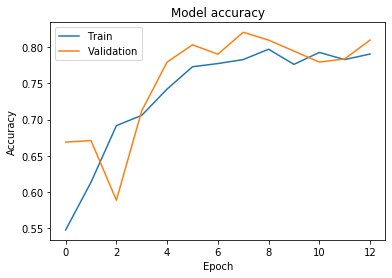

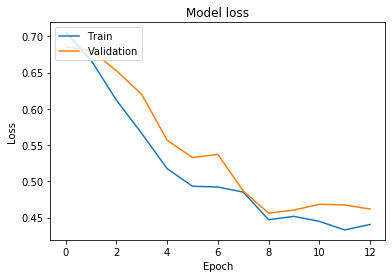

F1 score is:  0.79
Recall score is:  0.79
Precision score is:  0.79
Confusion matrix: 
 [[108  36]
 [ 24 120]]
From the confusion matrix above there are 108 true negatives and 36 false positives.
There are 24 false negatives and 120 true positives. 

ResNet50 RI Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 43s 468ms/step - loss: 0.7018 - acc: 0.5196 - val_loss: 0.6890 - val_acc: 0.6623

Epoch 00001: val_loss improved from inf to 0.68904, saving model to ./model/ResNet50 RI Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 29s 311ms/step - loss: 0.6903 - acc: 0.5619 - val_loss: 0.6913 - val_acc: 0.5281

Epoch 00002: val_loss did not improve from 0.68904
Epoch 3/50

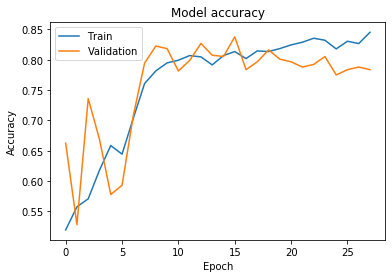

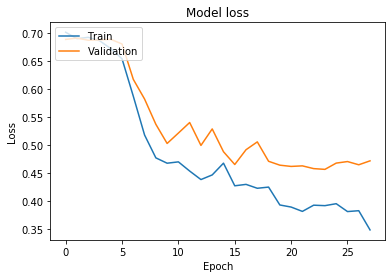

F1 score is:  0.81
Recall score is:  0.81
Precision score is:  0.81
Confusion matrix: 
 [[123  21]
 [ 33 111]]
From the confusion matrix above there are 123 true negatives and 21 false positives.
There are 33 false negatives and 111 true positives. 

ResNet50 RI Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 43s 470ms/step - loss: 0.7041 - acc: 0.5761 - val_loss: 0.6865 - val_acc: 0.7143

Epoch 00001: val_loss improved from inf to 0.68653, saving model to ./model/ResNet50 RI Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 29s 312ms/step - loss: 0.6838 - acc: 0.6001 - val_loss: 0.6861 - val_acc: 0.7100

Epoch 00002: val_loss improved from 0.68653 to 0.68614, savin

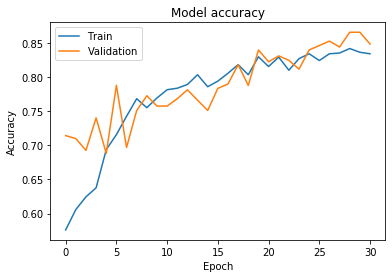

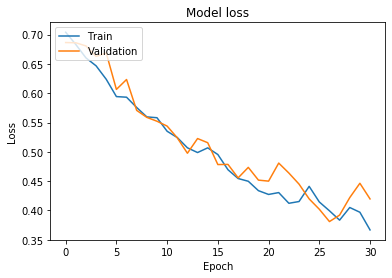

F1 score is:  0.84
Recall score is:  0.84
Precision score is:  0.84
Confusion matrix: 
 [[110  34]
 [ 13 131]]
From the confusion matrix above there are 110 true negatives and 34 false positives.
There are 13 false negatives and 131 true positives. 

EfficientNet B4 RI Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 99s 1s/step - loss: 0.6894 - acc: 0.5674 - val_loss: 0.6795 - val_acc: 0.5173

Epoch 00001: val_loss improved from inf to 0.67952, saving model to ./model/EfficientNet B4 RI Dropout: 0.2_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 65s 701ms/step - loss: 0.6643 - acc: 0.6033 - val_loss: 0.7004 - val_acc: 0.5087

Epoch 00002: val_loss did not improve from 0

92/92 [==============================] - 65s 703ms/step - loss: 0.5025 - acc: 0.7783 - val_loss: 0.6032 - val_acc: 0.6061

Epoch 00034: val_loss did not improve from 0.59511
Epoch 35/50
92/92 [==============================] - 65s 703ms/step - loss: 0.5039 - acc: 0.7696 - val_loss: 0.6008 - val_acc: 0.6147

Epoch 00035: val_loss did not improve from 0.59511
Epoch 00035: early stopping
validating_size 231 val_preds (231, 2) y_val:  (231, 2)
EfficientNet B4 RI Dropout: 0.2 : Counter: 0, Accuracies: Validation: 62.34 %, Test: 64.24 %


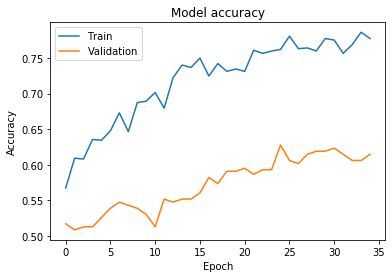

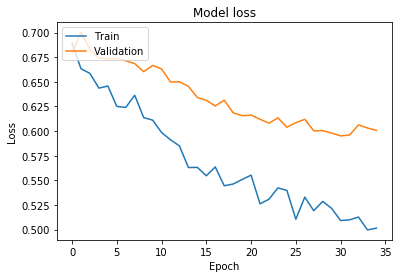

F1 score is:  0.59
Recall score is:  0.79
Precision score is:  0.64
Confusion matrix: 
 [[144   0]
 [103  41]]
From the confusion matrix above there are 144 true negatives and 0 false positives.
There are 103 false negatives and 41 true positives. 

EfficientNet B4 RI Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 99s 1s/step - loss: 0.6953 - acc: 0.5467 - val_loss: 0.7468 - val_acc: 0.5346

Epoch 00001: val_loss improved from inf to 0.74675, saving model to ./model/EfficientNet B4 RI Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 65s 705ms/step - loss: 0.6688 - acc: 0.6184 - val_loss: 0.6707 - val_acc: 0.5866

Epoch 00002: val_loss improved from 0.74675 t

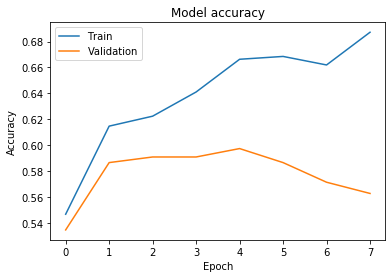

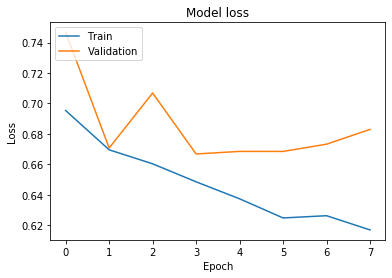

F1 score is:  0.57
Recall score is:  0.71
Precision score is:  0.61
Confusion matrix: 
 [[137   7]
 [104  40]]
From the confusion matrix above there are 137 true negatives and 7 false positives.
There are 104 false negatives and 40 true positives. 

EfficientNet B4 RI Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 99s 1s/step - loss: 0.7234 - acc: 0.4924 - val_loss: 0.7198 - val_acc: 0.4762

Epoch 00001: val_loss improved from inf to 0.71982, saving model to ./model/EfficientNet B4 RI Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 64s 698ms/step - loss: 0.7027 - acc: 0.5185 - val_loss: 0.7069 - val_acc: 0.6450

Epoch 00002: val_loss improved from 0.71982 t

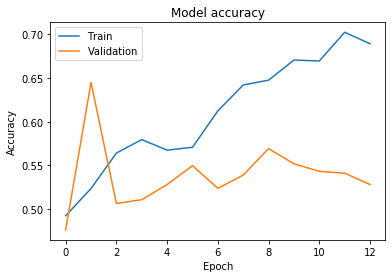

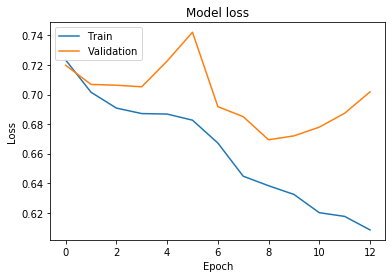

F1 score is:  0.48
Recall score is:  0.71
Precision score is:  0.57
Confusion matrix: 
 [[141   3]
 [121  23]]
From the confusion matrix above there are 141 true negatives and 3 false positives.
There are 121 false negatives and 23 true positives. 

Validation score of Ensemble of 1 & 2:  80.09 %
Test score of Ensemble of 1 & 2:  81.25 %
F1 score is:  0.81
Recall score is:  0.81
Precision score is:  0.81
Confusion matrix: 
 [[117  27]
 [ 27 117]]
From the confusion matrix above there are 117 true negatives and 27 false positives.
There are 27 false negatives and 117 true positives. 

results_data 

   Counter  ResNet50 RI Dropout: 0.2 Val Acc  \
0       0                             81.39   

   ResNet50 RI Dropout: 0.2 Test Acc  ResNet50 RI Dropout: 0.2 F1 score  \
0                              79.17                               0.79   

   ResNet50 RI Dropout: 0.2 Precision  ResNet50 RI Dropout: 0.2 Recall  \
0                                0.79                             0.79   

Epoch 27/50
92/92 [==============================] - 29s 314ms/step - loss: 0.3893 - acc: 0.8195 - val_loss: 0.3441 - val_acc: 0.8658

Epoch 00027: val_loss improved from 0.34646 to 0.34408, saving model to ./model/ResNet50 RI Dropout: 0.2_RI_bestmodel.hdf5
Epoch 28/50
92/92 [==============================] - 29s 314ms/step - loss: 0.3959 - acc: 0.8239 - val_loss: 0.3430 - val_acc: 0.8658

Epoch 00028: val_loss improved from 0.34408 to 0.34299, saving model to ./model/ResNet50 RI Dropout: 0.2_RI_bestmodel.hdf5
Epoch 29/50
92/92 [==============================] - 29s 314ms/step - loss: 0.3635 - acc: 0.8456 - val_loss: 0.3422 - val_acc: 0.8701

Epoch 00029: val_loss improved from 0.34299 to 0.34219, saving model to ./model/ResNet50 RI Dropout: 0.2_RI_bestmodel.hdf5
Epoch 30/50
92/92 [==============================] - 29s 314ms/step - loss: 0.3608 - acc: 0.8511 - val_loss: 0.3442 - val_acc: 0.8658

Epoch 00030: val_loss did not improve from 0.34219
Epoch 31/50
92/92 [=====================

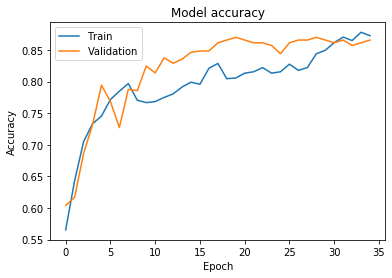

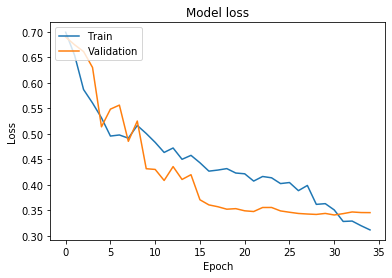

F1 score is:  0.83
Recall score is:  0.83
Precision score is:  0.83
Confusion matrix: 
 [[120  24]
 [ 25 119]]
From the confusion matrix above there are 120 true negatives and 24 false positives.
There are 25 false negatives and 119 true positives. 

ResNet50 RI Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 88s 960ms/step - loss: 0.7265 - acc: 0.5435 - val_loss: 0.6928 - val_acc: 0.5390

Epoch 00001: val_loss improved from inf to 0.69283, saving model to ./model/ResNet50 RI Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 29s 319ms/step - loss: 0.6858 - acc: 0.5521 - val_loss: 0.6900 - val_acc: 0.6537

Epoch 00002: val_loss improved from 0.69283 to 0.69003, savin

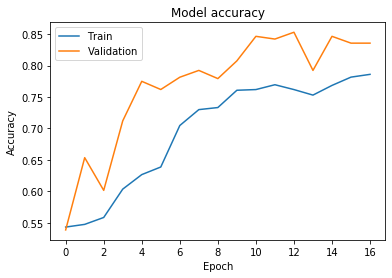

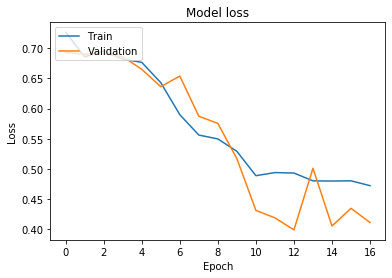

F1 score is:  0.8
Recall score is:  0.8
Precision score is:  0.8
Confusion matrix: 
 [[114  30]
 [ 28 116]]
From the confusion matrix above there are 114 true negatives and 30 false positives.
There are 28 false negatives and 116 true positives. 

ResNet50 RI Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 43s 469ms/step - loss: 0.7788 - acc: 0.4870 - val_loss: 0.6911 - val_acc: 0.6234

Epoch 00001: val_loss improved from inf to 0.69111, saving model to ./model/ResNet50 RI Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 29s 311ms/step - loss: 0.6942 - acc: 0.5282 - val_loss: 0.6931 - val_acc: 0.5238

Epoch 00002: val_loss did not improve from 0.69111
Epoch 3/50
92

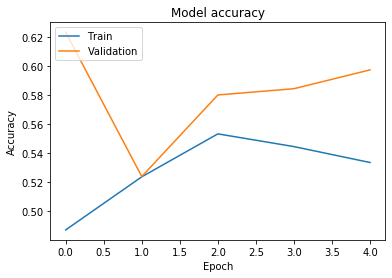

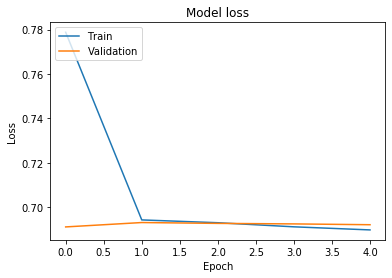

F1 score is:  0.57
Recall score is:  0.71
Precision score is:  0.62
Confusion matrix: 
 [[137   7]
 [103  41]]
From the confusion matrix above there are 137 true negatives and 7 false positives.
There are 103 false negatives and 41 true positives. 

EfficientNet B4 RI Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 98s 1s/step - loss: 0.6916 - acc: 0.5533 - val_loss: 0.6545 - val_acc: 0.5974

Epoch 00001: val_loss improved from inf to 0.65452, saving model to ./model/EfficientNet B4 RI Dropout: 0.2_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 64s 701ms/step - loss: 0.6727 - acc: 0.6022 - val_loss: 0.7231 - val_acc: 0.5758

Epoch 00002: val_loss did not improve from 0.

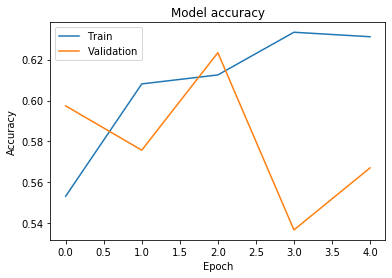

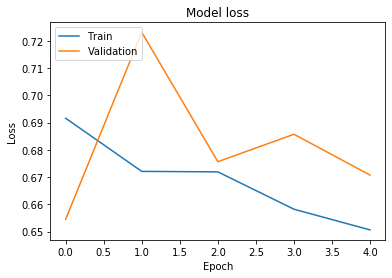

F1 score is:  0.61
Recall score is:  0.72
Precision score is:  0.64
Confusion matrix: 
 [[135   9]
 [ 94  50]]
From the confusion matrix above there are 135 true negatives and 9 false positives.
There are 94 false negatives and 50 true positives. 

EfficientNet B4 RI Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 98s 1s/step - loss: 0.7041 - acc: 0.5337 - val_loss: 0.7172 - val_acc: 0.5584

Epoch 00001: val_loss improved from inf to 0.71723, saving model to ./model/EfficientNet B4 RI Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 64s 700ms/step - loss: 0.6825 - acc: 0.5631 - val_loss: 0.6979 - val_acc: 0.5498

Epoch 00002: val_loss improved from 0.71723 to

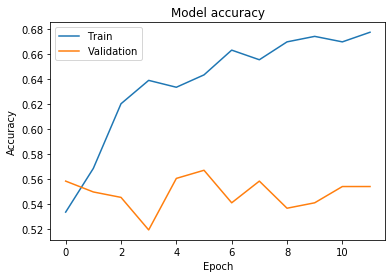

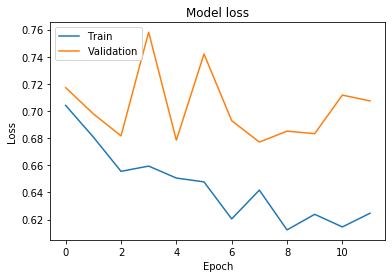

F1 score is:  0.46
Recall score is:  0.77
Precision score is:  0.56
Confusion matrix: 
 [[144   0]
 [126  18]]
From the confusion matrix above there are 144 true negatives and 0 false positives.
There are 126 false negatives and 18 true positives. 

EfficientNet B4 RI Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 98s 1s/step - loss: 0.6988 - acc: 0.5185 - val_loss: 0.6844 - val_acc: 0.5411

Epoch 00001: val_loss improved from inf to 0.68443, saving model to ./model/EfficientNet B4 RI Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 64s 700ms/step - loss: 0.7061 - acc: 0.5185 - val_loss: 0.6744 - val_acc: 0.5671

Epoch 00002: val_loss improved from 0.68443 t

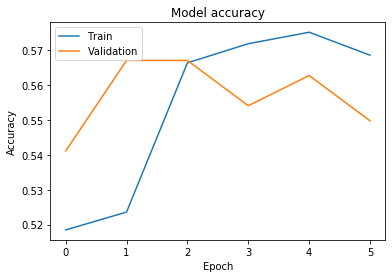

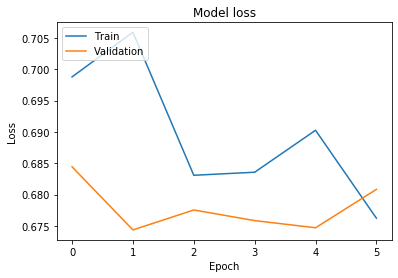

F1 score is:  0.49
Recall score is:  0.71
Precision score is:  0.57
Confusion matrix: 
 [[141   3]
 [120  24]]
From the confusion matrix above there are 141 true negatives and 3 false positives.
There are 120 false negatives and 24 true positives. 

Validation score of Ensemble of 1 & 2:  86.58 %
Test score of Ensemble of 1 & 2:  80.21 %
F1 score is:  0.8
Recall score is:  0.8
Precision score is:  0.8
Confusion matrix: 
 [[114  30]
 [ 27 117]]
From the confusion matrix above there are 114 true negatives and 30 false positives.
There are 27 false negatives and 117 true positives. 

results_data 

   Counter  ResNet50 RI Dropout: 0.2 Val Acc  \
0       0                             81.39   
1       1                             86.15   

   ResNet50 RI Dropout: 0.2 Test Acc  ResNet50 RI Dropout: 0.2 F1 score  \
0                              79.17                               0.79   
1                              82.99                               0.83   

   ResNet50 RI Dropout: 0.2 

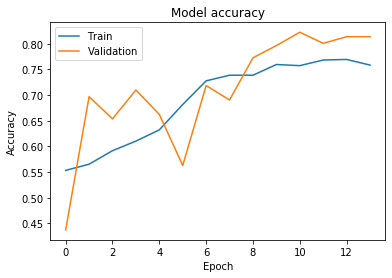

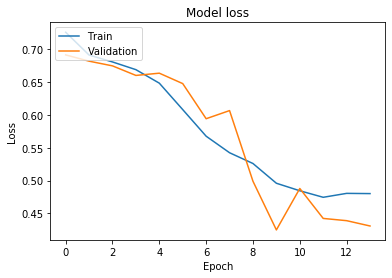

F1 score is:  0.8
Recall score is:  0.81
Precision score is:  0.8
Confusion matrix: 
 [[127  17]
 [ 41 103]]
From the confusion matrix above there are 127 true negatives and 17 false positives.
There are 41 false negatives and 103 true positives. 

ResNet50 RI Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 43s 468ms/step - loss: 0.6983 - acc: 0.5207 - val_loss: 0.6888 - val_acc: 0.7056

Epoch 00001: val_loss improved from inf to 0.68881, saving model to ./model/ResNet50 RI Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 29s 313ms/step - loss: 0.6937 - acc: 0.5510 - val_loss: 0.6876 - val_acc: 0.5714

Epoch 00002: val_loss improved from 0.68881 to 0.68763, saving 

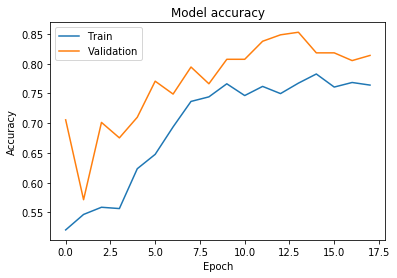

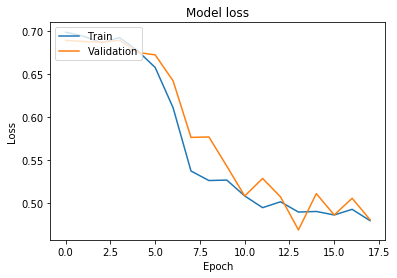

F1 score is:  0.8
Recall score is:  0.8
Precision score is:  0.8
Confusion matrix: 
 [[119  25]
 [ 32 112]]
From the confusion matrix above there are 119 true negatives and 25 false positives.
There are 32 false negatives and 112 true positives. 

ResNet50 RI Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 43s 464ms/step - loss: 0.7671 - acc: 0.5196 - val_loss: 1.9668 - val_acc: 0.5022

Epoch 00001: val_loss improved from inf to 1.96680, saving model to ./model/ResNet50 RI Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 29s 313ms/step - loss: 0.7008 - acc: 0.4990 - val_loss: 0.6922 - val_acc: 0.5952

Epoch 00002: val_loss improved from 1.96680 to 0.69221, saving m

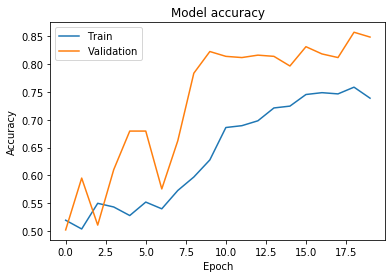

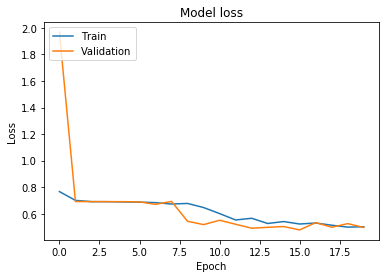

F1 score is:  0.78
Recall score is:  0.79
Precision score is:  0.78
Confusion matrix: 
 [[109  35]
 [ 27 117]]
From the confusion matrix above there are 109 true negatives and 35 false positives.
There are 27 false negatives and 117 true positives. 

EfficientNet B4 RI Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 99s 1s/step - loss: 0.7082 - acc: 0.4957 - val_loss: 0.6877 - val_acc: 0.5281

Epoch 00001: val_loss improved from inf to 0.68766, saving model to ./model/EfficientNet B4 RI Dropout: 0.2_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 65s 703ms/step - loss: 0.6790 - acc: 0.5880 - val_loss: 0.6614 - val_acc: 0.5844

Epoch 00002: val_loss improved from 0.68766 

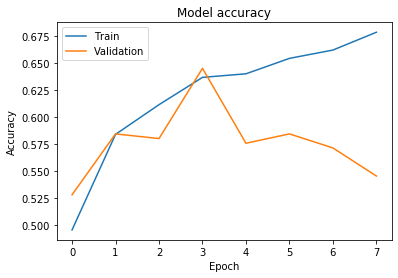

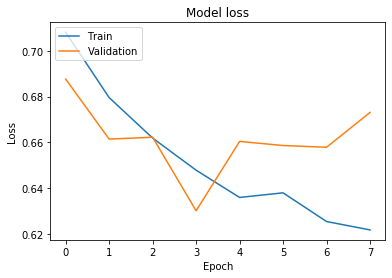

F1 score is:  0.61
Recall score is:  0.78
Precision score is:  0.66
Confusion matrix: 
 [[142   2]
 [ 97  47]]
From the confusion matrix above there are 142 true negatives and 2 false positives.
There are 97 false negatives and 47 true positives. 

EfficientNet B4 RI Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 99s 1s/step - loss: 0.7293 - acc: 0.4880 - val_loss: 0.6540 - val_acc: 0.6147

Epoch 00001: val_loss improved from inf to 0.65397, saving model to ./model/EfficientNet B4 RI Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 64s 701ms/step - loss: 0.6739 - acc: 0.5793 - val_loss: 0.6778 - val_acc: 0.5455

Epoch 00002: val_loss did not improve from 0.6

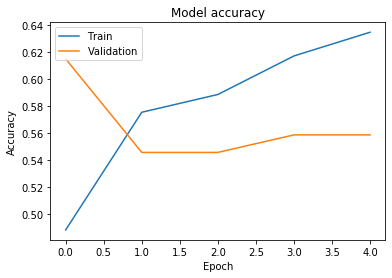

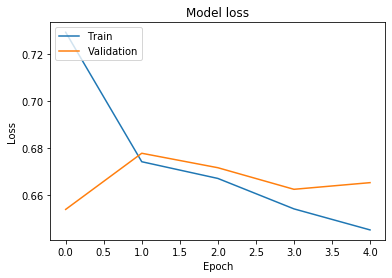

F1 score is:  0.56
Recall score is:  0.79
Precision score is:  0.62
Confusion matrix: 
 [[144   0]
 [108  36]]
From the confusion matrix above there are 144 true negatives and 0 false positives.
There are 108 false negatives and 36 true positives. 

EfficientNet B4 RI Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 99s 1s/step - loss: 0.6989 - acc: 0.5043 - val_loss: 0.7115 - val_acc: 0.6234

Epoch 00001: val_loss improved from inf to 0.71150, saving model to ./model/EfficientNet B4 RI Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 65s 701ms/step - loss: 0.6794 - acc: 0.5847 - val_loss: 0.7684 - val_acc: 0.6320

Epoch 00002: val_loss did not improve from 0.

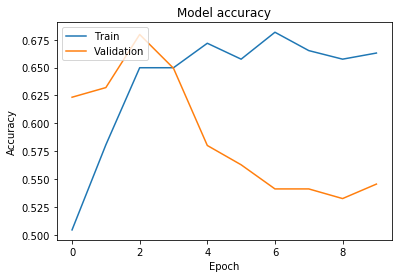

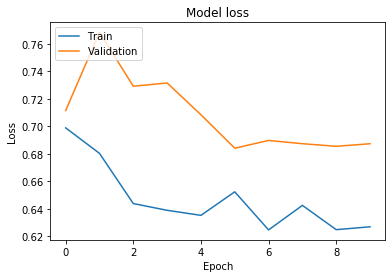

F1 score is:  0.52
Recall score is:  0.73
Precision score is:  0.59
Confusion matrix: 
 [[141   3]
 [115  29]]
From the confusion matrix above there are 141 true negatives and 3 false positives.
There are 115 false negatives and 29 true positives. 

Validation score of Ensemble of 1 & 2:  82.25 %
Test score of Ensemble of 1 & 2:  80.21 %
F1 score is:  0.8
Recall score is:  0.8
Precision score is:  0.8
Confusion matrix: 
 [[121  23]
 [ 34 110]]
From the confusion matrix above there are 121 true negatives and 23 false positives.
There are 34 false negatives and 110 true positives. 

results_data 

   Counter  ResNet50 RI Dropout: 0.2 Val Acc  \
0       0                             81.39   
1       1                             86.15   
2       2                             79.65   

   ResNet50 RI Dropout: 0.2 Test Acc  ResNet50 RI Dropout: 0.2 F1 score  \
0                              79.17                               0.79   
1                              82.99                     

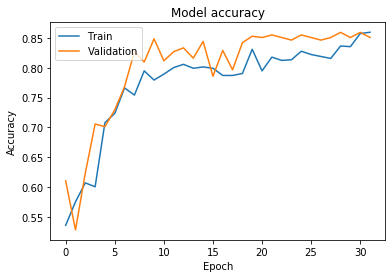

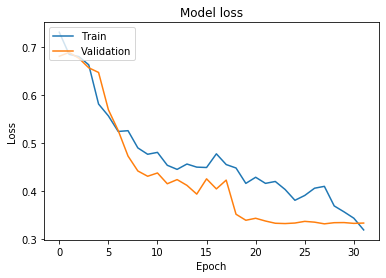

F1 score is:  0.82
Recall score is:  0.82
Precision score is:  0.82
Confusion matrix: 
 [[111  33]
 [ 20 124]]
From the confusion matrix above there are 111 true negatives and 33 false positives.
There are 20 false negatives and 124 true positives. 

ResNet50 RI Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 43s 468ms/step - loss: 0.6761 - acc: 0.6370 - val_loss: 0.6391 - val_acc: 0.6450

Epoch 00001: val_loss improved from inf to 0.63905, saving model to ./model/ResNet50 RI Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 29s 313ms/step - loss: 0.5633 - acc: 0.7353 - val_loss: 0.6029 - val_acc: 0.7706

Epoch 00002: val_loss improved from 0.63905 to 0.60289, savin

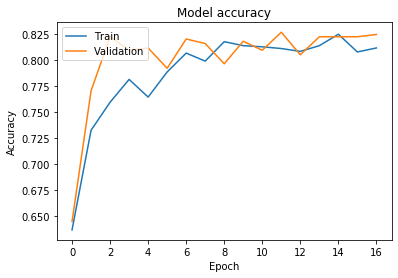

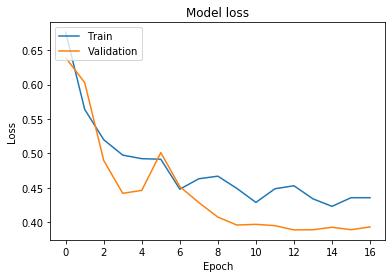

F1 score is:  0.83
Recall score is:  0.83
Precision score is:  0.83
Confusion matrix: 
 [[118  26]
 [ 23 121]]
From the confusion matrix above there are 118 true negatives and 26 false positives.
There are 23 false negatives and 121 true positives. 

ResNet50 RI Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 43s 467ms/step - loss: 0.6892 - acc: 0.5978 - val_loss: 0.6933 - val_acc: 0.5043

Epoch 00001: val_loss improved from inf to 0.69331, saving model to ./model/ResNet50 RI Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 29s 311ms/step - loss: 0.6949 - acc: 0.5370 - val_loss: 0.6901 - val_acc: 0.6537

Epoch 00002: val_loss improved from 0.69331 to 0.69013, savin

validating_size 231 val_preds (231, 2) y_val:  (231, 2)
ResNet50 RI Dropout: 0.4 : Counter: 3, Accuracies: Validation: 83.98 %, Test: 82.64 %


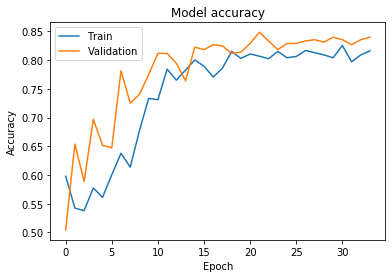

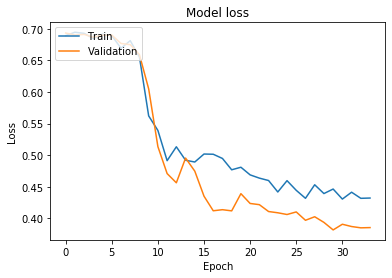

F1 score is:  0.83
Recall score is:  0.83
Precision score is:  0.83
Confusion matrix: 
 [[118  26]
 [ 24 120]]
From the confusion matrix above there are 118 true negatives and 26 false positives.
There are 24 false negatives and 120 true positives. 

EfficientNet B4 RI Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 98s 1s/step - loss: 0.6868 - acc: 0.5380 - val_loss: 0.6717 - val_acc: 0.5584

Epoch 00001: val_loss improved from inf to 0.67170, saving model to ./model/EfficientNet B4 RI Dropout: 0.2_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 64s 696ms/step - loss: 0.6612 - acc: 0.6424 - val_loss: 0.6617 - val_acc: 0.5844

Epoch 00002: val_loss improved from 0.67170 

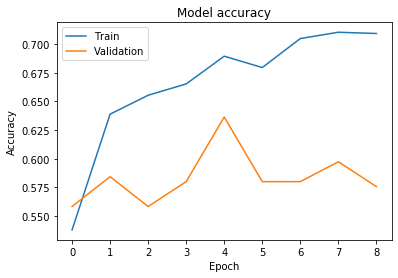

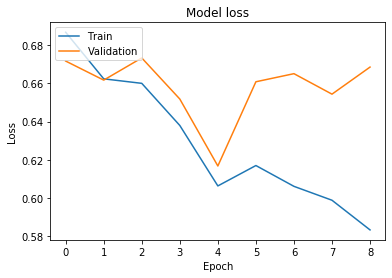

F1 score is:  0.63
Recall score is:  0.74
Precision score is:  0.66
Confusion matrix: 
 [[137   7]
 [ 90  54]]
From the confusion matrix above there are 137 true negatives and 7 false positives.
There are 90 false negatives and 54 true positives. 

EfficientNet B4 RI Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 98s 1s/step - loss: 0.6949 - acc: 0.5348 - val_loss: 0.6902 - val_acc: 0.5541

Epoch 00001: val_loss improved from inf to 0.69018, saving model to ./model/EfficientNet B4 RI Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 64s 692ms/step - loss: 0.6781 - acc: 0.5826 - val_loss: 0.6944 - val_acc: 0.5195

Epoch 00002: val_loss did not improve from 0.6

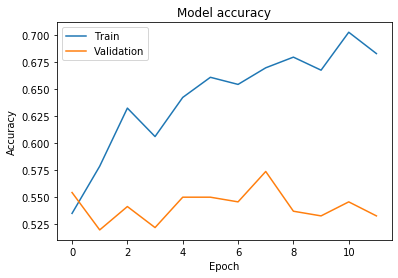

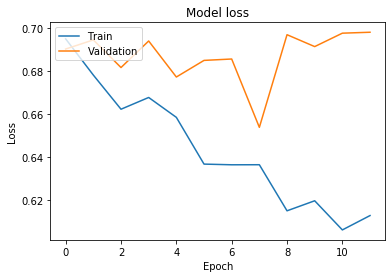

F1 score is:  0.56
Recall score is:  0.76
Precision score is:  0.62
Confusion matrix: 
 [[142   2]
 [107  37]]
From the confusion matrix above there are 142 true negatives and 2 false positives.
There are 107 false negatives and 37 true positives. 

EfficientNet B4 RI Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 98s 1s/step - loss: 0.7025 - acc: 0.5293 - val_loss: 0.6513 - val_acc: 0.6537

Epoch 00001: val_loss improved from inf to 0.65129, saving model to ./model/EfficientNet B4 RI Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 64s 698ms/step - loss: 0.6733 - acc: 0.6010 - val_loss: 0.6534 - val_acc: 0.5887

Epoch 00002: val_loss did not improve from 0.

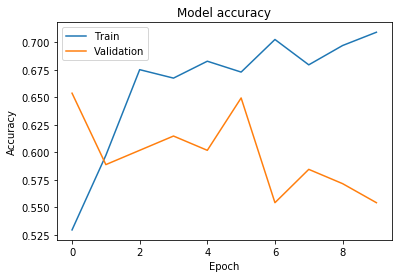

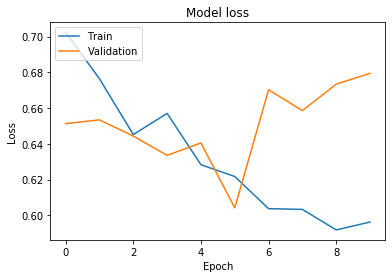

F1 score is:  0.68
Recall score is:  0.77
Precision score is:  0.7
Confusion matrix: 
 [[138   6]
 [ 80  64]]
From the confusion matrix above there are 138 true negatives and 6 false positives.
There are 80 false negatives and 64 true positives. 

Validation score of Ensemble of 1 & 2:  85.71 %
Test score of Ensemble of 1 & 2:  81.6 %
F1 score is:  0.82
Recall score is:  0.82
Precision score is:  0.82
Confusion matrix: 
 [[113  31]
 [ 22 122]]
From the confusion matrix above there are 113 true negatives and 31 false positives.
There are 22 false negatives and 122 true positives. 

results_data 

   Counter  ResNet50 RI Dropout: 0.2 Val Acc  \
0       0                             81.39   
1       1                             86.15   
2       2                             79.65   
3       3                             85.28   

   ResNet50 RI Dropout: 0.2 Test Acc  ResNet50 RI Dropout: 0.2 F1 score  \
0                              79.17                               0.79   
1         

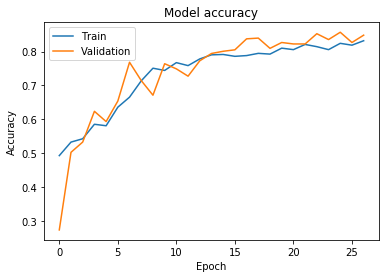

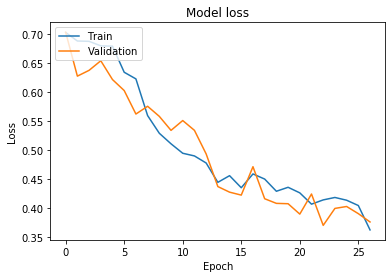

F1 score is:  0.84
Recall score is:  0.84
Precision score is:  0.84
Confusion matrix: 
 [[118  26]
 [ 20 124]]
From the confusion matrix above there are 118 true negatives and 26 false positives.
There are 20 false negatives and 124 true positives. 

ResNet50 RI Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 43s 466ms/step - loss: 0.7400 - acc: 0.4924 - val_loss: 0.7572 - val_acc: 0.5022

Epoch 00001: val_loss improved from inf to 0.75718, saving model to ./model/ResNet50 RI Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 29s 311ms/step - loss: 0.6895 - acc: 0.5228 - val_loss: 0.7028 - val_acc: 0.4892

Epoch 00002: val_loss improved from 0.75718 to 0.70281, savin

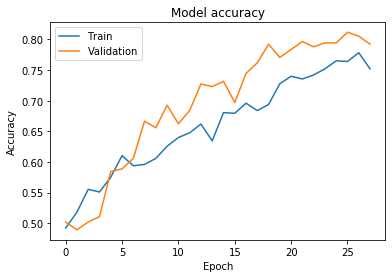

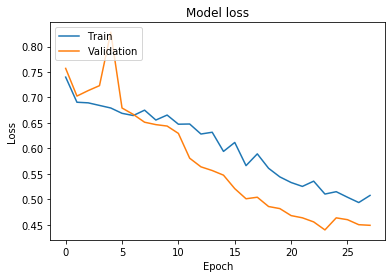

F1 score is:  0.79
Recall score is:  0.8
Precision score is:  0.79
Confusion matrix: 
 [[105  39]
 [ 21 123]]
From the confusion matrix above there are 105 true negatives and 39 false positives.
There are 21 false negatives and 123 true positives. 

ResNet50 RI Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 43s 467ms/step - loss: 0.7144 - acc: 0.5859 - val_loss: 0.6931 - val_acc: 0.6385

Epoch 00001: val_loss improved from inf to 0.69306, saving model to ./model/ResNet50 RI Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 29s 311ms/step - loss: 0.6894 - acc: 0.6066 - val_loss: 0.6873 - val_acc: 0.7251

Epoch 00002: val_loss improved from 0.69306 to 0.68730, saving

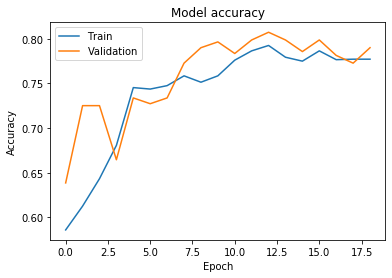

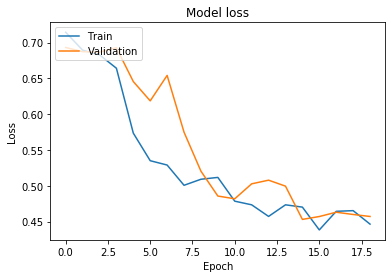

F1 score is:  0.81
Recall score is:  0.81
Precision score is:  0.81
Confusion matrix: 
 [[115  29]
 [ 26 118]]
From the confusion matrix above there are 115 true negatives and 29 false positives.
There are 26 false negatives and 118 true positives. 

EfficientNet B4 RI Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 98s 1s/step - loss: 0.7044 - acc: 0.4804 - val_loss: 0.7315 - val_acc: 0.5628

Epoch 00001: val_loss improved from inf to 0.73154, saving model to ./model/EfficientNet B4 RI Dropout: 0.2_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 64s 697ms/step - loss: 0.6922 - acc: 0.5131 - val_loss: 0.6641 - val_acc: 0.6515

Epoch 00002: val_loss improved from 0.73154 

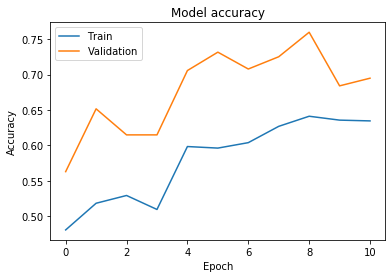

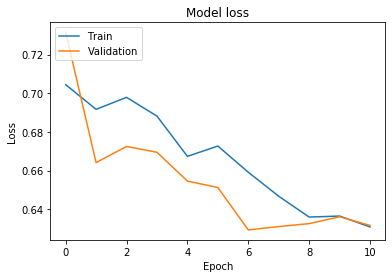

F1 score is:  0.7
Recall score is:  0.74
Precision score is:  0.71
Confusion matrix: 
 [[ 76  68]
 [ 16 128]]
From the confusion matrix above there are 76 true negatives and 68 false positives.
There are 16 false negatives and 128 true positives. 

EfficientNet B4 RI Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 98s 1s/step - loss: 0.6695 - acc: 0.5793 - val_loss: 0.7357 - val_acc: 0.5584

Epoch 00001: val_loss improved from inf to 0.73568, saving model to ./model/EfficientNet B4 RI Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 64s 700ms/step - loss: 0.6545 - acc: 0.6251 - val_loss: 0.7083 - val_acc: 0.6061

Epoch 00002: val_loss improved from 0.73568 to

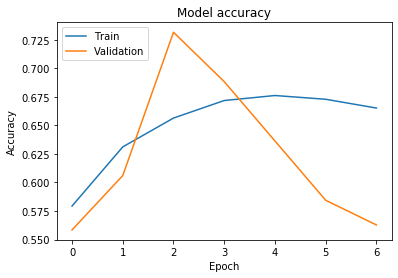

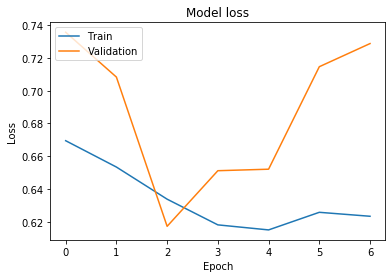

F1 score is:  0.71
Recall score is:  0.76
Precision score is:  0.72
Confusion matrix: 
 [[132  12]
 [ 69  75]]
From the confusion matrix above there are 132 true negatives and 12 false positives.
There are 69 false negatives and 75 true positives. 

EfficientNet B4 RI Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 98s 1s/step - loss: 0.6727 - acc: 0.5478 - val_loss: 0.6691 - val_acc: 0.7100

Epoch 00001: val_loss improved from inf to 0.66910, saving model to ./model/EfficientNet B4 RI Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 64s 700ms/step - loss: 0.6351 - acc: 0.6392 - val_loss: 0.6589 - val_acc: 0.7013

Epoch 00002: val_loss improved from 0.66910 t

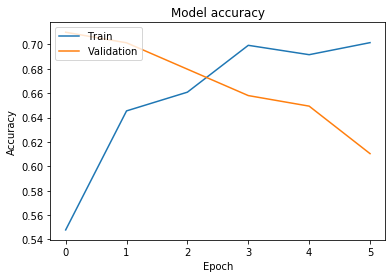

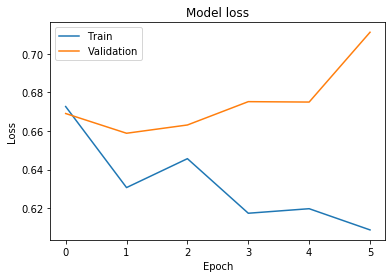

F1 score is:  0.64
Recall score is:  0.74
Precision score is:  0.67
Confusion matrix: 
 [[135   9]
 [ 87  57]]
From the confusion matrix above there are 135 true negatives and 9 false positives.
There are 87 false negatives and 57 true positives. 

Validation score of Ensemble of 1 & 2:  83.98 %
Test score of Ensemble of 1 & 2:  84.03 %
F1 score is:  0.84
Recall score is:  0.84
Precision score is:  0.84
Confusion matrix: 
 [[117  27]
 [ 19 125]]
From the confusion matrix above there are 117 true negatives and 27 false positives.
There are 19 false negatives and 125 true positives. 

results_data 

   Counter  ResNet50 RI Dropout: 0.2 Val Acc  \
0       0                             81.39   
1       1                             86.15   
2       2                             79.65   
3       3                             85.28   
4       4                             85.28   

   ResNet50 RI Dropout: 0.2 Test Acc  ResNet50 RI Dropout: 0.2 F1 score  \
0                              79.17


Epoch 00014: val_loss did not improve from 0.43494
Epoch 15/50
92/92 [==============================] - 29s 314ms/step - loss: 0.4152 - acc: 0.8163 - val_loss: 0.4573 - val_acc: 0.8182

Epoch 00015: val_loss did not improve from 0.43494
Epoch 16/50
92/92 [==============================] - 29s 314ms/step - loss: 0.4084 - acc: 0.8337 - val_loss: 0.4175 - val_acc: 0.8268

Epoch 00016: val_loss improved from 0.43494 to 0.41755, saving model to ./model/ResNet50 RI Dropout: 0.2_RI_bestmodel.hdf5
Epoch 17/50
92/92 [==============================] - 29s 314ms/step - loss: 0.4004 - acc: 0.8099 - val_loss: 0.4145 - val_acc: 0.8398

Epoch 00017: val_loss improved from 0.41755 to 0.41450, saving model to ./model/ResNet50 RI Dropout: 0.2_RI_bestmodel.hdf5
Epoch 18/50
92/92 [==============================] - 29s 314ms/step - loss: 0.4087 - acc: 0.8088 - val_loss: 0.4114 - val_acc: 0.8398

Epoch 00018: val_loss improved from 0.41450 to 0.41143, saving model to ./model/ResNet50 RI Dropout: 0.2_RI_bes

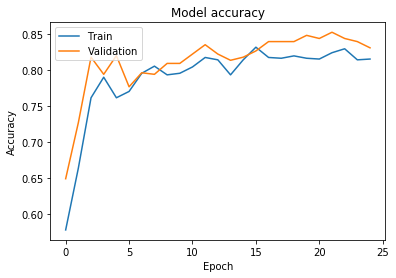

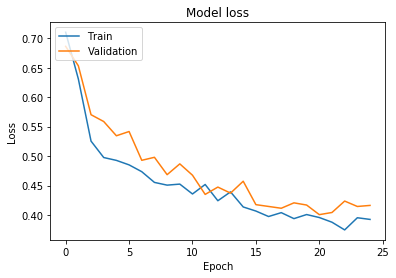

F1 score is:  0.81
Recall score is:  0.81
Precision score is:  0.81
Confusion matrix: 
 [[115  29]
 [ 25 119]]
From the confusion matrix above there are 115 true negatives and 29 false positives.
There are 25 false negatives and 119 true positives. 

ResNet50 RI Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 43s 467ms/step - loss: 0.7134 - acc: 0.4902 - val_loss: 0.6955 - val_acc: 0.2987

Epoch 00001: val_loss improved from inf to 0.69550, saving model to ./model/ResNet50 RI Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 29s 311ms/step - loss: 0.6935 - acc: 0.4956 - val_loss: 0.6931 - val_acc: 0.5455

Epoch 00002: val_loss improved from 0.69550 to 0.69312, savin

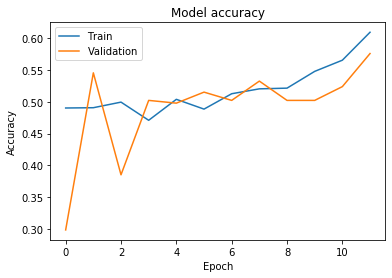

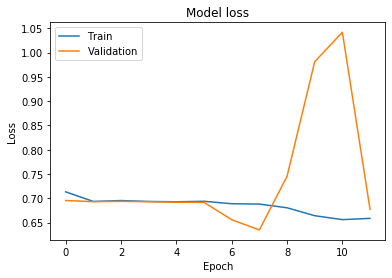

F1 score is:  0.4
Recall score is:  0.64
Precision score is:  0.52
Confusion matrix: 
 [[141   3]
 [134  10]]
From the confusion matrix above there are 141 true negatives and 3 false positives.
There are 134 false negatives and 10 true positives. 

ResNet50 RI Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 43s 465ms/step - loss: 0.7463 - acc: 0.5011 - val_loss: 0.6913 - val_acc: 0.6494

Epoch 00001: val_loss improved from inf to 0.69129, saving model to ./model/ResNet50 RI Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 29s 311ms/step - loss: 0.6888 - acc: 0.5213 - val_loss: 0.6904 - val_acc: 0.6017

Epoch 00002: val_loss improved from 0.69129 to 0.69036, saving 

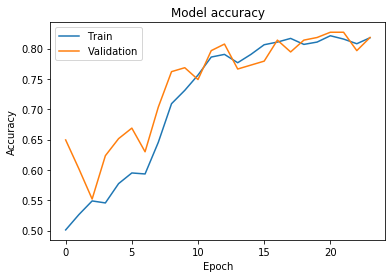

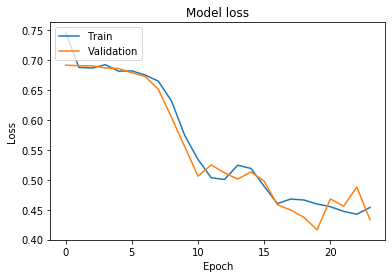

F1 score is:  0.83
Recall score is:  0.83
Precision score is:  0.83
Confusion matrix: 
 [[116  28]
 [ 22 122]]
From the confusion matrix above there are 116 true negatives and 28 false positives.
There are 22 false negatives and 122 true positives. 

EfficientNet B4 RI Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 99s 1s/step - loss: 0.7085 - acc: 0.5228 - val_loss: 0.8109 - val_acc: 0.5584

Epoch 00001: val_loss improved from inf to 0.81091, saving model to ./model/EfficientNet B4 RI Dropout: 0.2_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 64s 697ms/step - loss: 0.6980 - acc: 0.5229 - val_loss: 0.6963 - val_acc: 0.5541

Epoch 00002: val_loss improved from 0.81091 

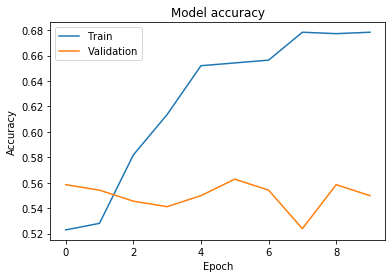

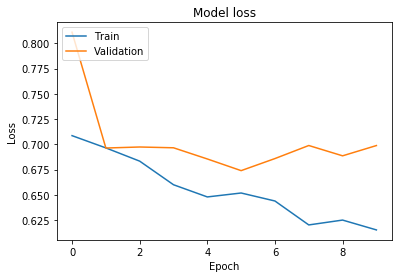

F1 score is:  0.56
Recall score is:  0.72
Precision score is:  0.61
Confusion matrix: 
 [[139   5]
 [107  37]]
From the confusion matrix above there are 139 true negatives and 5 false positives.
There are 107 false negatives and 37 true positives. 

EfficientNet B4 RI Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 99s 1s/step - loss: 0.6828 - acc: 0.5609 - val_loss: 0.8075 - val_acc: 0.5671

Epoch 00001: val_loss improved from inf to 0.80746, saving model to ./model/EfficientNet B4 RI Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 64s 698ms/step - loss: 0.6896 - acc: 0.5805 - val_loss: 0.7011 - val_acc: 0.6407

Epoch 00002: val_loss improved from 0.80746 t

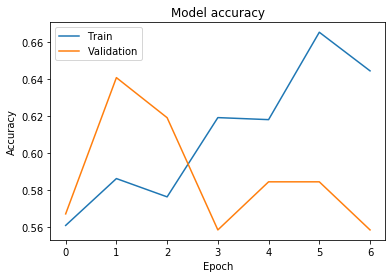

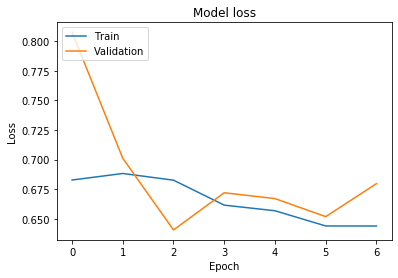

F1 score is:  0.65
Recall score is:  0.74
Precision score is:  0.67
Confusion matrix: 
 [[135   9]
 [ 85  59]]
From the confusion matrix above there are 135 true negatives and 9 false positives.
There are 85 false negatives and 59 true positives. 

EfficientNet B4 RI Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 98s 1s/step - loss: 0.6751 - acc: 0.5641 - val_loss: 0.6426 - val_acc: 0.6364

Epoch 00001: val_loss improved from inf to 0.64262, saving model to ./model/EfficientNet B4 RI Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 65s 704ms/step - loss: 0.6642 - acc: 0.5990 - val_loss: 0.6611 - val_acc: 0.5844

Epoch 00002: val_loss did not improve from 0.6

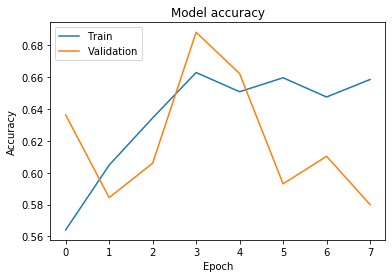

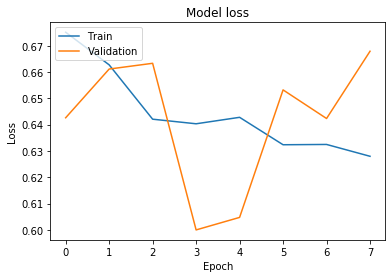

F1 score is:  0.7
Recall score is:  0.77
Precision score is:  0.72
Confusion matrix: 
 [[135   9]
 [ 72  72]]
From the confusion matrix above there are 135 true negatives and 9 false positives.
There are 72 false negatives and 72 true positives. 

Validation score of Ensemble of 1 & 2:  84.85 %
Test score of Ensemble of 1 & 2:  81.6 %
F1 score is:  0.82
Recall score is:  0.82
Precision score is:  0.82
Confusion matrix: 
 [[118  26]
 [ 27 117]]
From the confusion matrix above there are 118 true negatives and 26 false positives.
There are 27 false negatives and 117 true positives. 

results_data 

   Counter  ResNet50 RI Dropout: 0.2 Val Acc  \
0       0                             81.39   
1       1                             86.15   
2       2                             79.65   
3       3                             85.28   
4       4                             85.28   
5       5                             84.42   

   ResNet50 RI Dropout: 0.2 Test Acc  ResNet50 RI Dropout: 0.2 F1 

Epoch 12/50
92/92 [==============================] - 29s 312ms/step - loss: 0.4410 - acc: 0.8054 - val_loss: 0.3776 - val_acc: 0.8355

Epoch 00012: val_loss improved from 0.37995 to 0.37763, saving model to ./model/ResNet50 RI Dropout: 0.2_RI_bestmodel.hdf5
Epoch 13/50
92/92 [==============================] - 29s 312ms/step - loss: 0.4311 - acc: 0.8087 - val_loss: 0.3723 - val_acc: 0.8528

Epoch 00013: val_loss improved from 0.37763 to 0.37230, saving model to ./model/ResNet50 RI Dropout: 0.2_RI_bestmodel.hdf5
Epoch 14/50
92/92 [==============================] - 29s 313ms/step - loss: 0.4460 - acc: 0.8001 - val_loss: 0.3736 - val_acc: 0.8139

Epoch 00014: val_loss did not improve from 0.37230
Epoch 15/50
92/92 [==============================] - 29s 312ms/step - loss: 0.4418 - acc: 0.8110 - val_loss: 0.3748 - val_acc: 0.8225

Epoch 00015: val_loss did not improve from 0.37230
Epoch 16/50
92/92 [==============================] - 29s 312ms/step - loss: 0.4477 - acc: 0.7957 - val_loss: 0.3

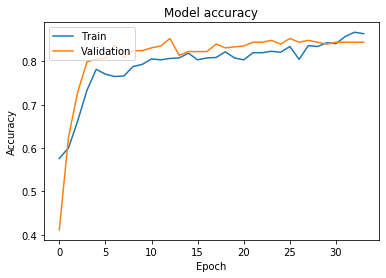

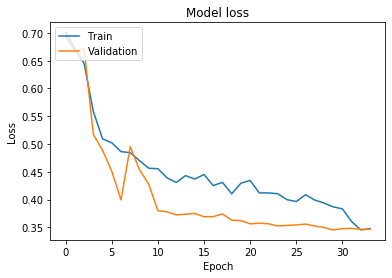

F1 score is:  0.82
Recall score is:  0.82
Precision score is:  0.82
Confusion matrix: 
 [[120  24]
 [ 27 117]]
From the confusion matrix above there are 120 true negatives and 24 false positives.
There are 27 false negatives and 117 true positives. 

ResNet50 RI Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 43s 467ms/step - loss: 0.7108 - acc: 0.6130 - val_loss: 0.6766 - val_acc: 0.7229

Epoch 00001: val_loss improved from inf to 0.67656, saving model to ./model/ResNet50 RI Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 29s 312ms/step - loss: 0.6113 - acc: 0.6968 - val_loss: 0.6375 - val_acc: 0.7749

Epoch 00002: val_loss improved from 0.67656 to 0.63745, savin

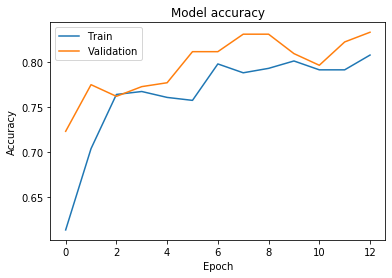

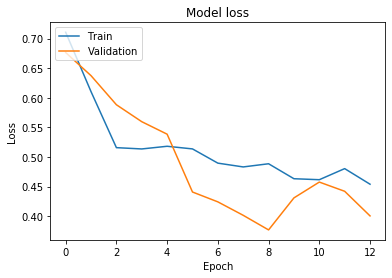

F1 score is:  0.82
Recall score is:  0.82
Precision score is:  0.82
Confusion matrix: 
 [[114  30]
 [ 23 121]]
From the confusion matrix above there are 114 true negatives and 30 false positives.
There are 23 false negatives and 121 true positives. 

ResNet50 RI Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 43s 469ms/step - loss: 0.7156 - acc: 0.5076 - val_loss: 0.6921 - val_acc: 0.4848

Epoch 00001: val_loss improved from inf to 0.69214, saving model to ./model/ResNet50 RI Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 29s 313ms/step - loss: 0.6923 - acc: 0.5163 - val_loss: 0.6899 - val_acc: 0.7078

Epoch 00002: val_loss improved from 0.69214 to 0.68989, savin

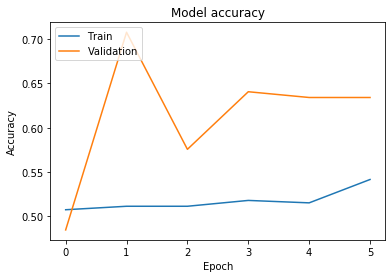

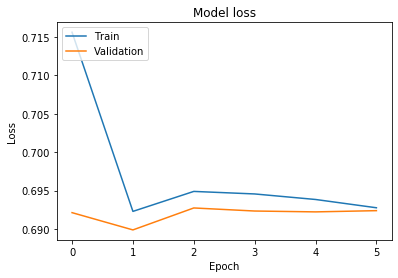

F1 score is:  0.72
Recall score is:  0.72
Precision score is:  0.72
Confusion matrix: 
 [[110  34]
 [ 47  97]]
From the confusion matrix above there are 110 true negatives and 34 false positives.
There are 47 false negatives and 97 true positives. 

EfficientNet B4 RI Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 98s 1s/step - loss: 0.7025 - acc: 0.5098 - val_loss: 0.6873 - val_acc: 0.4978

Epoch 00001: val_loss improved from inf to 0.68731, saving model to ./model/EfficientNet B4 RI Dropout: 0.2_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 65s 705ms/step - loss: 0.6843 - acc: 0.5304 - val_loss: 0.6926 - val_acc: 0.6623

Epoch 00002: val_loss did not improve from 0.

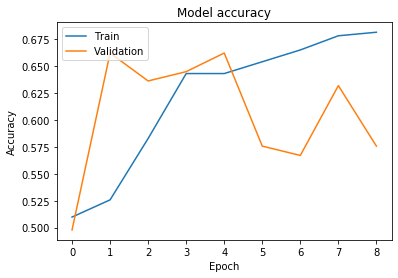

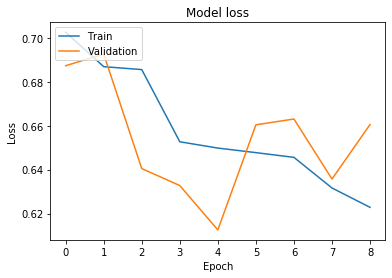

F1 score is:  0.62
Recall score is:  0.75
Precision score is:  0.66
Confusion matrix: 
 [[139   5]
 [ 94  50]]
From the confusion matrix above there are 139 true negatives and 5 false positives.
There are 94 false negatives and 50 true positives. 

EfficientNet B4 RI Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 98s 1s/step - loss: 0.6963 - acc: 0.5261 - val_loss: 0.7707 - val_acc: 0.5022

Epoch 00001: val_loss improved from inf to 0.77069, saving model to ./model/EfficientNet B4 RI Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 64s 699ms/step - loss: 0.7038 - acc: 0.5109 - val_loss: 0.7534 - val_acc: 0.5368

Epoch 00002: val_loss improved from 0.77069 to

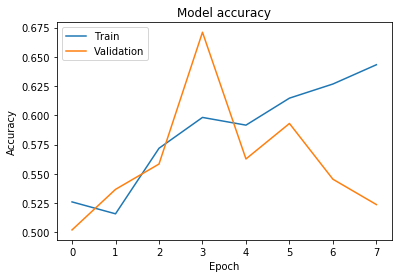

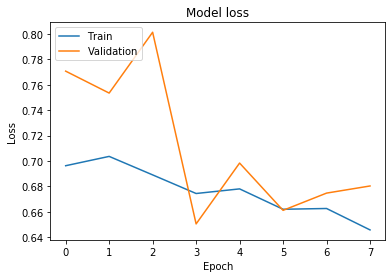

F1 score is:  0.61
Recall score is:  0.7
Precision score is:  0.64
Confusion matrix: 
 [[131  13]
 [ 90  54]]
From the confusion matrix above there are 131 true negatives and 13 false positives.
There are 90 false negatives and 54 true positives. 

EfficientNet B4 RI Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 98s 1s/step - loss: 0.6959 - acc: 0.5207 - val_loss: 0.7074 - val_acc: 0.4719

Epoch 00001: val_loss improved from inf to 0.70741, saving model to ./model/EfficientNet B4 RI Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 65s 701ms/step - loss: 0.6953 - acc: 0.5294 - val_loss: 0.7060 - val_acc: 0.4892

Epoch 00002: val_loss improved from 0.70741 to

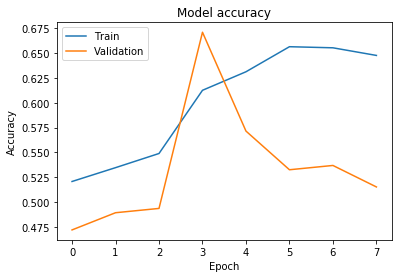

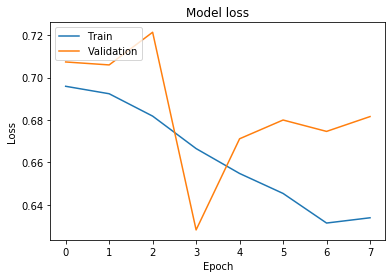

F1 score is:  0.62
Recall score is:  0.73
Precision score is:  0.65
Confusion matrix: 
 [[136   8]
 [ 92  52]]
From the confusion matrix above there are 136 true negatives and 8 false positives.
There are 92 false negatives and 52 true positives. 

Validation score of Ensemble of 1 & 2:  84.42 %
Test score of Ensemble of 1 & 2:  81.6 %
F1 score is:  0.82
Recall score is:  0.82
Precision score is:  0.82
Confusion matrix: 
 [[117  27]
 [ 26 118]]
From the confusion matrix above there are 117 true negatives and 27 false positives.
There are 26 false negatives and 118 true positives. 

results_data 

   Counter  ResNet50 RI Dropout: 0.2 Val Acc  \
0       0                             81.39   
1       1                             86.15   
2       2                             79.65   
3       3                             85.28   
4       4                             85.28   
5       5                             84.42   
6       6                             83.98   

   ResNet50 RI Dro

Epoch 9/50
92/92 [==============================] - 29s 312ms/step - loss: 0.4955 - acc: 0.7669 - val_loss: 0.4788 - val_acc: 0.7749

Epoch 00009: val_loss improved from 0.48627 to 0.47878, saving model to ./model/ResNet50 RI Dropout: 0.2_RI_bestmodel.hdf5
Epoch 10/50
92/92 [==============================] - 29s 313ms/step - loss: 0.5036 - acc: 0.7849 - val_loss: 0.4949 - val_acc: 0.8009

Epoch 00010: val_loss did not improve from 0.47878
Epoch 11/50
92/92 [==============================] - 29s 313ms/step - loss: 0.4864 - acc: 0.7860 - val_loss: 0.5043 - val_acc: 0.7944

Epoch 00011: val_loss did not improve from 0.47878
Epoch 12/50
92/92 [==============================] - 29s 313ms/step - loss: 0.4780 - acc: 0.7903 - val_loss: 0.4866 - val_acc: 0.8074

Epoch 00012: val_loss did not improve from 0.47878
Epoch 13/50
92/92 [==============================] - 29s 312ms/step - loss: 0.4457 - acc: 0.8141 - val_loss: 0.4885 - val_acc: 0.8052

Epoch 00013: val_loss did not improve from 0.47878

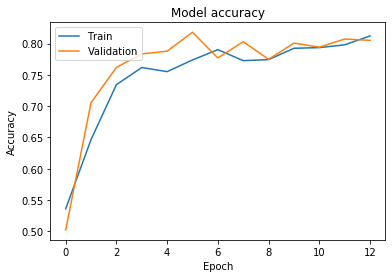

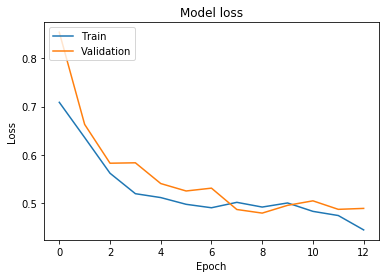

F1 score is:  0.75
Recall score is:  0.75
Precision score is:  0.75
Confusion matrix: 
 [[107  37]
 [ 35 109]]
From the confusion matrix above there are 107 true negatives and 37 false positives.
There are 35 false negatives and 109 true positives. 

ResNet50 RI Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 43s 467ms/step - loss: 0.7212 - acc: 0.4717 - val_loss: 0.6945 - val_acc: 0.4113

Epoch 00001: val_loss improved from inf to 0.69446, saving model to ./model/ResNet50 RI Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 29s 311ms/step - loss: 0.6979 - acc: 0.4642 - val_loss: 0.6935 - val_acc: 0.4502

Epoch 00002: val_loss improved from 0.69446 to 0.69346, savin

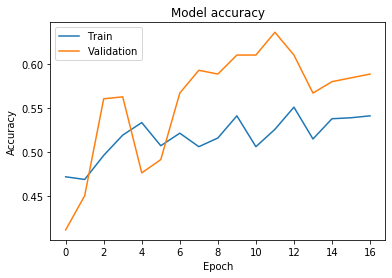

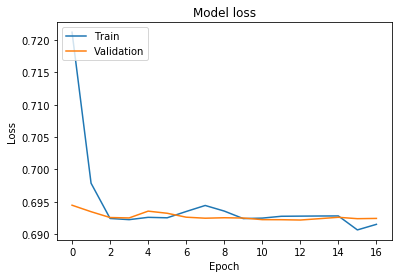

F1 score is:  0.53
Recall score is:  0.63
Precision score is:  0.58
Confusion matrix: 
 [[ 38 106]
 [ 16 128]]
From the confusion matrix above there are 38 true negatives and 106 false positives.
There are 16 false negatives and 128 true positives. 

ResNet50 RI Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 43s 467ms/step - loss: 0.7497 - acc: 0.4946 - val_loss: 0.6946 - val_acc: 0.4827

Epoch 00001: val_loss improved from inf to 0.69463, saving model to ./model/ResNet50 RI Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 29s 311ms/step - loss: 0.6975 - acc: 0.4923 - val_loss: 0.6924 - val_acc: 0.5541

Epoch 00002: val_loss improved from 0.69463 to 0.69238, savin

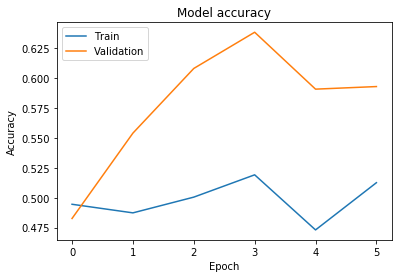

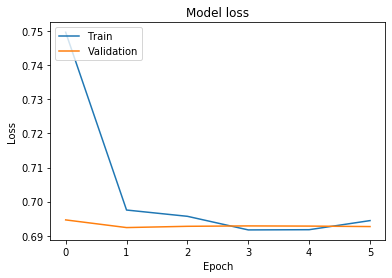

F1 score is:  0.49
Recall score is:  0.64
Precision score is:  0.56
Confusion matrix: 
 [[ 26 118]
 [  9 135]]
From the confusion matrix above there are 26 true negatives and 118 false positives.
There are 9 false negatives and 135 true positives. 

EfficientNet B4 RI Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 97s 1s/step - loss: 0.6795 - acc: 0.5489 - val_loss: 0.6678 - val_acc: 0.6710

Epoch 00001: val_loss improved from inf to 0.66776, saving model to ./model/EfficientNet B4 RI Dropout: 0.2_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 64s 694ms/step - loss: 0.6590 - acc: 0.6315 - val_loss: 0.6072 - val_acc: 0.6732

Epoch 00002: val_loss improved from 0.66776 t

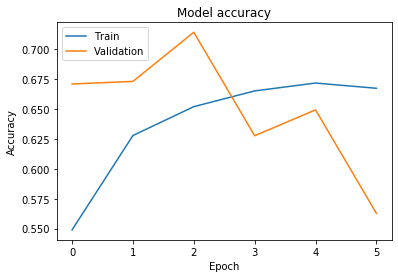

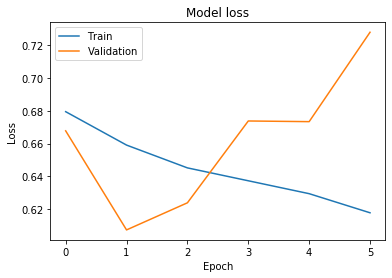

F1 score is:  0.66
Recall score is:  0.75
Precision score is:  0.68
Confusion matrix: 
 [[136   8]
 [ 84  60]]
From the confusion matrix above there are 136 true negatives and 8 false positives.
There are 84 false negatives and 60 true positives. 

EfficientNet B4 RI Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 99s 1s/step - loss: 0.6902 - acc: 0.5587 - val_loss: 0.6815 - val_acc: 0.6147

Epoch 00001: val_loss improved from inf to 0.68152, saving model to ./model/EfficientNet B4 RI Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 64s 697ms/step - loss: 0.6795 - acc: 0.5923 - val_loss: 0.6638 - val_acc: 0.5606

Epoch 00002: val_loss improved from 0.68152 to

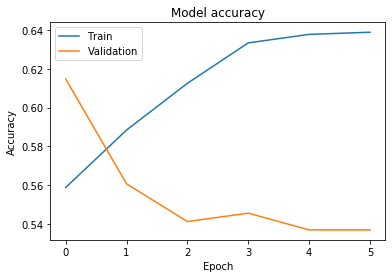

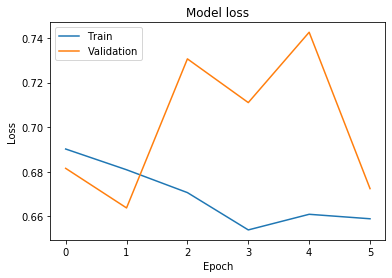

F1 score is:  0.53
Recall score is:  0.72
Precision score is:  0.6
Confusion matrix: 
 [[140   4]
 [112  32]]
From the confusion matrix above there are 140 true negatives and 4 false positives.
There are 112 false negatives and 32 true positives. 

EfficientNet B4 RI Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 98s 1s/step - loss: 0.7250 - acc: 0.4946 - val_loss: 0.7046 - val_acc: 0.4892

Epoch 00001: val_loss improved from inf to 0.70459, saving model to ./model/EfficientNet B4 RI Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 64s 700ms/step - loss: 0.7055 - acc: 0.5108 - val_loss: 0.6866 - val_acc: 0.6883

Epoch 00002: val_loss improved from 0.70459 to

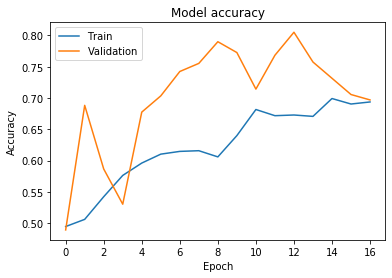

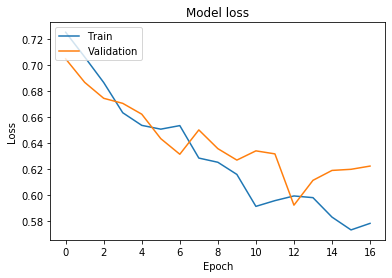

F1 score is:  0.78
Recall score is:  0.8
Precision score is:  0.78
Confusion matrix: 
 [[130  14]
 [ 48  96]]
From the confusion matrix above there are 130 true negatives and 14 false positives.
There are 48 false negatives and 96 true positives. 

Validation score of Ensemble of 1 & 2:  79.65 %
Test score of Ensemble of 1 & 2:  74.65 %
F1 score is:  0.75
Recall score is:  0.75
Precision score is:  0.75
Confusion matrix: 
 [[106  38]
 [ 35 109]]
From the confusion matrix above there are 106 true negatives and 38 false positives.
There are 35 false negatives and 109 true positives. 

results_data 

   Counter  ResNet50 RI Dropout: 0.2 Val Acc  \
0       0                             81.39   
1       1                             86.15   
2       2                             79.65   
3       3                             85.28   
4       4                             85.28   
5       5                             84.42   
6       6                             83.98   
7       7         

92/92 [==============================] - 29s 313ms/step - loss: 0.6868 - acc: 0.5706 - val_loss: 0.6814 - val_acc: 0.6883

Epoch 00006: val_loss improved from 0.68410 to 0.68137, saving model to ./model/ResNet50 RI Dropout: 0.2_RI_bestmodel.hdf5
Epoch 7/50
92/92 [==============================] - 29s 312ms/step - loss: 0.6848 - acc: 0.5729 - val_loss: 0.6816 - val_acc: 0.5801

Epoch 00007: val_loss did not improve from 0.68137
Epoch 8/50
92/92 [==============================] - 29s 313ms/step - loss: 0.6919 - acc: 0.5706 - val_loss: 0.6798 - val_acc: 0.6623

Epoch 00008: val_loss improved from 0.68137 to 0.67980, saving model to ./model/ResNet50 RI Dropout: 0.2_RI_bestmodel.hdf5
Epoch 9/50
92/92 [==============================] - 29s 313ms/step - loss: 0.6683 - acc: 0.6054 - val_loss: 0.6543 - val_acc: 0.6753

Epoch 00009: val_loss improved from 0.67980 to 0.65430, saving model to ./model/ResNet50 RI Dropout: 0.2_RI_bestmodel.hdf5
Epoch 10/50
92/92 [==============================] - 29

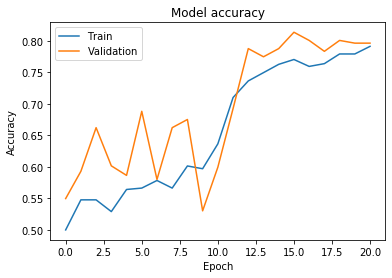

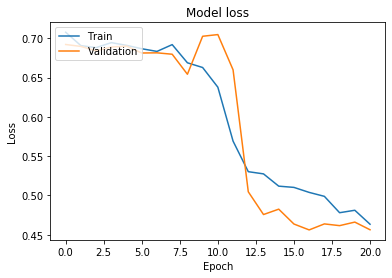

F1 score is:  0.83
Recall score is:  0.83
Precision score is:  0.83
Confusion matrix: 
 [[121  23]
 [ 26 118]]
From the confusion matrix above there are 121 true negatives and 23 false positives.
There are 26 false negatives and 118 true positives. 

ResNet50 RI Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 43s 465ms/step - loss: 0.7058 - acc: 0.4641 - val_loss: 0.6934 - val_acc: 0.5260

Epoch 00001: val_loss improved from inf to 0.69341, saving model to ./model/ResNet50 RI Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 29s 311ms/step - loss: 0.6939 - acc: 0.4815 - val_loss: 0.6935 - val_acc: 0.5693

Epoch 00002: val_loss did not improve from 0.69341
Epoch 3/50

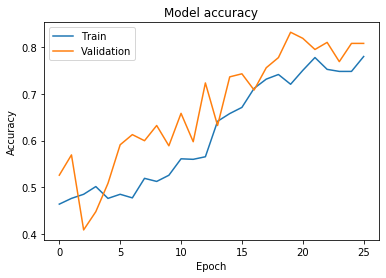

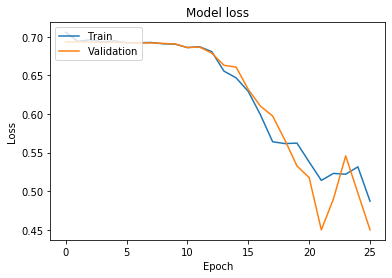

F1 score is:  0.83
Recall score is:  0.83
Precision score is:  0.83
Confusion matrix: 
 [[121  23]
 [ 25 119]]
From the confusion matrix above there are 121 true negatives and 23 false positives.
There are 25 false negatives and 119 true positives. 

ResNet50 RI Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 43s 465ms/step - loss: 0.7447 - acc: 0.5739 - val_loss: 0.6888 - val_acc: 0.6948

Epoch 00001: val_loss improved from inf to 0.68876, saving model to ./model/ResNet50 RI Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 29s 310ms/step - loss: 0.7038 - acc: 0.5174 - val_loss: 0.6909 - val_acc: 0.6017

Epoch 00002: val_loss did not improve from 0.68876
Epoch 3/50

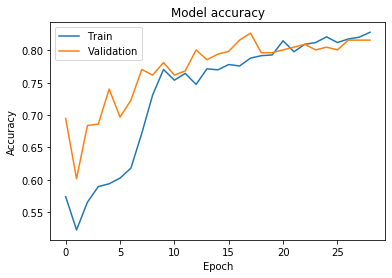

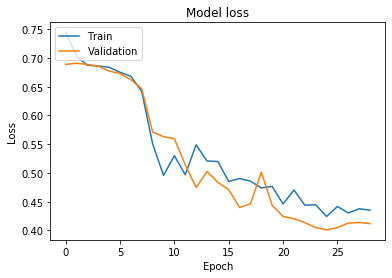

F1 score is:  0.84
Recall score is:  0.84
Precision score is:  0.84
Confusion matrix: 
 [[121  23]
 [ 22 122]]
From the confusion matrix above there are 121 true negatives and 23 false positives.
There are 22 false negatives and 122 true positives. 

EfficientNet B4 RI Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 98s 1s/step - loss: 0.6972 - acc: 0.5217 - val_loss: 0.7843 - val_acc: 0.5108

Epoch 00001: val_loss improved from inf to 0.78430, saving model to ./model/EfficientNet B4 RI Dropout: 0.2_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 64s 699ms/step - loss: 0.6868 - acc: 0.5673 - val_loss: 0.7592 - val_acc: 0.5195

Epoch 00002: val_loss improved from 0.78430 

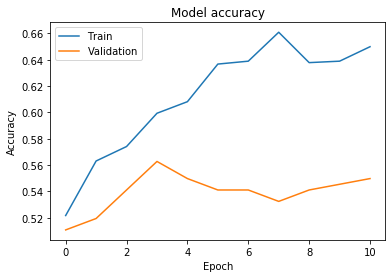

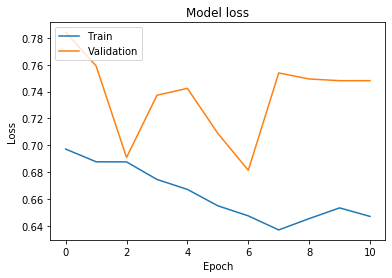

F1 score is:  0.38
Recall score is:  0.69
Precision score is:  0.52
Confusion matrix: 
 [[143   1]
 [137   7]]
From the confusion matrix above there are 143 true negatives and 1 false positives.
There are 137 false negatives and 7 true positives. 

EfficientNet B4 RI Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 99s 1s/step - loss: 0.7059 - acc: 0.5228 - val_loss: 0.6868 - val_acc: 0.5390

Epoch 00001: val_loss improved from inf to 0.68679, saving model to ./model/EfficientNet B4 RI Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 64s 692ms/step - loss: 0.6966 - acc: 0.5434 - val_loss: 0.6744 - val_acc: 0.5909

Epoch 00002: val_loss improved from 0.68679 to

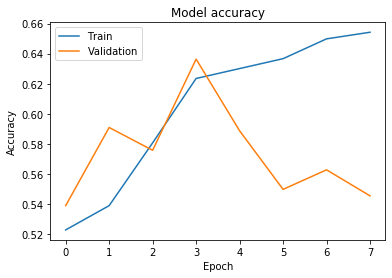

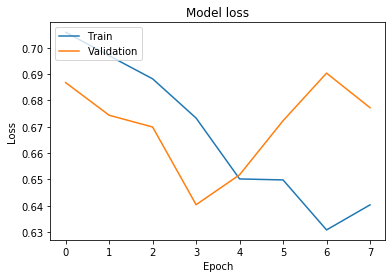

F1 score is:  0.64
Recall score is:  0.73
Precision score is:  0.66
Confusion matrix: 
 [[135   9]
 [ 88  56]]
From the confusion matrix above there are 135 true negatives and 9 false positives.
There are 88 false negatives and 56 true positives. 

EfficientNet B4 RI Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 97s 1s/step - loss: 0.6986 - acc: 0.5413 - val_loss: 0.7272 - val_acc: 0.7013

Epoch 00001: val_loss improved from inf to 0.72719, saving model to ./model/EfficientNet B4 RI Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 65s 703ms/step - loss: 0.6494 - acc: 0.6337 - val_loss: 0.7101 - val_acc: 0.5844

Epoch 00002: val_loss improved from 0.72719 to

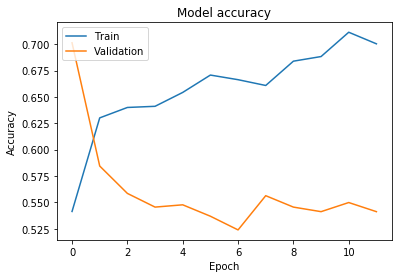

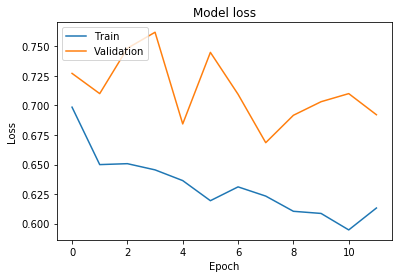

F1 score is:  0.46
Recall score is:  0.74
Precision score is:  0.56
Confusion matrix: 
 [[143   1]
 [125  19]]
From the confusion matrix above there are 143 true negatives and 1 false positives.
There are 125 false negatives and 19 true positives. 

Validation score of Ensemble of 1 & 2:  80.09 %
Test score of Ensemble of 1 & 2:  82.64 %
F1 score is:  0.83
Recall score is:  0.83
Precision score is:  0.83
Confusion matrix: 
 [[121  23]
 [ 27 117]]
From the confusion matrix above there are 121 true negatives and 23 false positives.
There are 27 false negatives and 117 true positives. 

results_data 

   Counter  ResNet50 RI Dropout: 0.2 Val Acc  \
0       0                             81.39   
1       1                             86.15   
2       2                             79.65   
3       3                             85.28   
4       4                             85.28   
5       5                             84.42   
6       6                             83.98   
7       7        

Epoch 3/50
92/92 [==============================] - 29s 312ms/step - loss: 0.6696 - acc: 0.6174 - val_loss: 0.6758 - val_acc: 0.7165

Epoch 00003: val_loss improved from 0.67749 to 0.67583, saving model to ./model/ResNet50 RI Dropout: 0.2_RI_bestmodel.hdf5
Epoch 4/50
92/92 [==============================] - 29s 312ms/step - loss: 0.6385 - acc: 0.6599 - val_loss: 0.6605 - val_acc: 0.7035

Epoch 00004: val_loss improved from 0.67583 to 0.66054, saving model to ./model/ResNet50 RI Dropout: 0.2_RI_bestmodel.hdf5
Epoch 5/50
92/92 [==============================] - 29s 313ms/step - loss: 0.5591 - acc: 0.7218 - val_loss: 0.5657 - val_acc: 0.7965

Epoch 00005: val_loss improved from 0.66054 to 0.56572, saving model to ./model/ResNet50 RI Dropout: 0.2_RI_bestmodel.hdf5
Epoch 6/50
92/92 [==============================] - 29s 313ms/step - loss: 0.5223 - acc: 0.7619 - val_loss: 0.5574 - val_acc: 0.7835

Epoch 00006: val_loss improved from 0.56572 to 0.55744, saving model to ./model/ResNet50 RI Dro

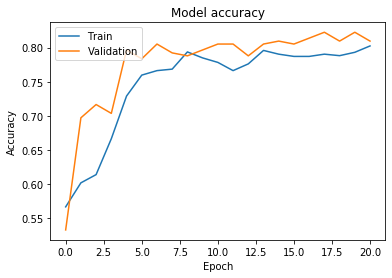

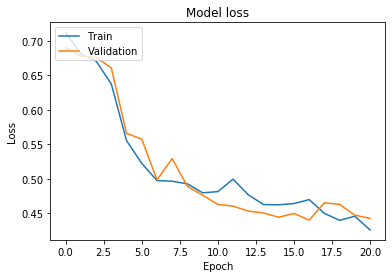

F1 score is:  0.8
Recall score is:  0.8
Precision score is:  0.8
Confusion matrix: 
 [[110  34]
 [ 23 121]]
From the confusion matrix above there are 110 true negatives and 34 false positives.
There are 23 false negatives and 121 true positives. 

ResNet50 RI Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 43s 467ms/step - loss: 0.7176 - acc: 0.5239 - val_loss: 0.6894 - val_acc: 0.5931

Epoch 00001: val_loss improved from inf to 0.68939, saving model to ./model/ResNet50 RI Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 29s 312ms/step - loss: 0.6949 - acc: 0.5380 - val_loss: 0.6903 - val_acc: 0.6710

Epoch 00002: val_loss did not improve from 0.68939
Epoch 3/50
92

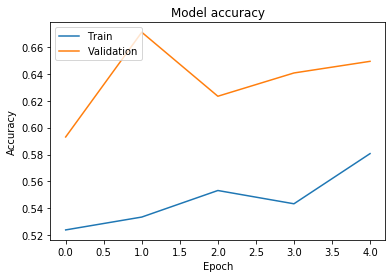

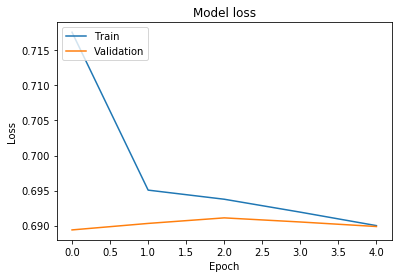

F1 score is:  0.57
Recall score is:  0.58
Precision score is:  0.58
Confusion matrix: 
 [[ 67  77]
 [ 44 100]]
From the confusion matrix above there are 67 true negatives and 77 false positives.
There are 44 false negatives and 100 true positives. 

ResNet50 RI Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 43s 468ms/step - loss: 0.7280 - acc: 0.5424 - val_loss: 0.6843 - val_acc: 0.4589

Epoch 00001: val_loss improved from inf to 0.68429, saving model to ./model/ResNet50 RI Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 29s 312ms/step - loss: 0.6461 - acc: 0.6380 - val_loss: 1.4345 - val_acc: 0.5281

Epoch 00002: val_loss did not improve from 0.68429
Epoch 3/50


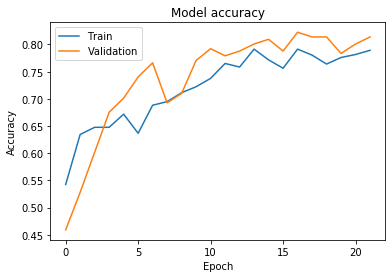

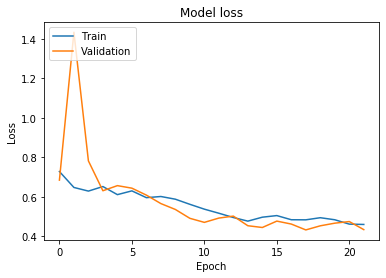

F1 score is:  0.81
Recall score is:  0.82
Precision score is:  0.81
Confusion matrix: 
 [[103  41]
 [ 13 131]]
From the confusion matrix above there are 103 true negatives and 41 false positives.
There are 13 false negatives and 131 true positives. 

EfficientNet B4 RI Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 98s 1s/step - loss: 0.7150 - acc: 0.4793 - val_loss: 0.7610 - val_acc: 0.4870

Epoch 00001: val_loss improved from inf to 0.76103, saving model to ./model/EfficientNet B4 RI Dropout: 0.2_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 65s 702ms/step - loss: 0.6953 - acc: 0.5119 - val_loss: 0.7633 - val_acc: 0.5714

Epoch 00002: val_loss did not improve from 0

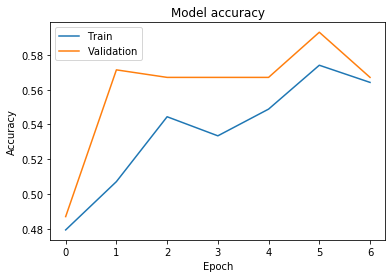

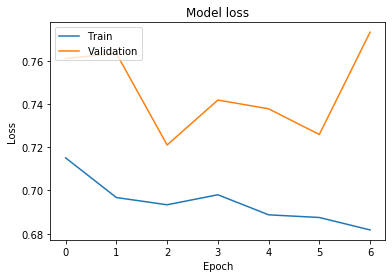

F1 score is:  0.47
Recall score is:  0.54
Precision score is:  0.52
Confusion matrix: 
 [[121  23]
 [114  30]]
From the confusion matrix above there are 121 true negatives and 23 false positives.
There are 114 false negatives and 30 true positives. 

EfficientNet B4 RI Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 98s 1s/step - loss: 0.7350 - acc: 0.4891 - val_loss: 0.6798 - val_acc: 0.5411

Epoch 00001: val_loss improved from inf to 0.67976, saving model to ./model/EfficientNet B4 RI Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 65s 706ms/step - loss: 0.7040 - acc: 0.5305 - val_loss: 0.6779 - val_acc: 0.5606

Epoch 00002: val_loss improved from 0.67976 

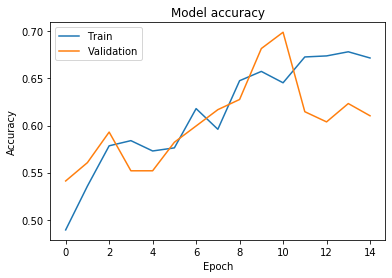

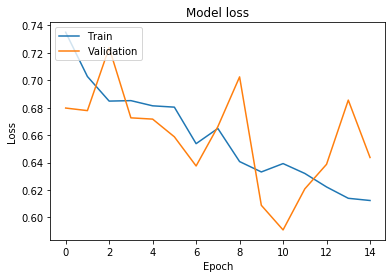

F1 score is:  0.69
Recall score is:  0.77
Precision score is:  0.7
Confusion matrix: 
 [[136   8]
 [ 77  67]]
From the confusion matrix above there are 136 true negatives and 8 false positives.
There are 77 false negatives and 67 true positives. 

EfficientNet B4 RI Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 99s 1s/step - loss: 0.7197 - acc: 0.4837 - val_loss: 0.7558 - val_acc: 0.5498

Epoch 00001: val_loss improved from inf to 0.75579, saving model to ./model/EfficientNet B4 RI Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 65s 703ms/step - loss: 0.6998 - acc: 0.5532 - val_loss: 0.7536 - val_acc: 0.5325

Epoch 00002: val_loss improved from 0.75579 to 

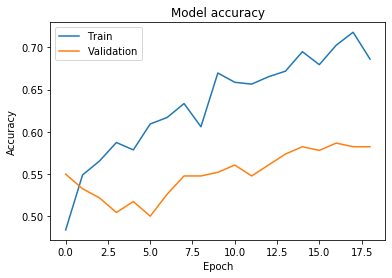

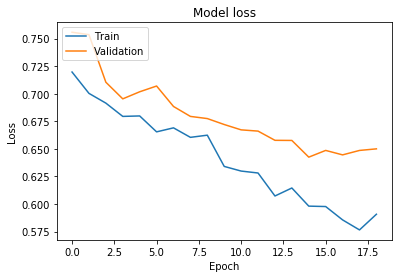

F1 score is:  0.56
Recall score is:  0.77
Precision score is:  0.62
Confusion matrix: 
 [[143   1]
 [108  36]]
From the confusion matrix above there are 143 true negatives and 1 false positives.
There are 108 false negatives and 36 true positives. 

Validation score of Ensemble of 1 & 2:  78.79 %
Test score of Ensemble of 1 & 2:  80.21 %
F1 score is:  0.8
Recall score is:  0.81
Precision score is:  0.8
Confusion matrix: 
 [[108  36]
 [ 21 123]]
From the confusion matrix above there are 108 true negatives and 36 false positives.
There are 21 false negatives and 123 true positives. 

results_data 

   Counter  ResNet50 RI Dropout: 0.2 Val Acc  \
0       0                             81.39   
1       1                             86.15   
2       2                             79.65   
3       3                             85.28   
4       4                             85.28   
5       5                             84.42   
6       6                             83.98   
7       7          

In [13]:
start = time.time()
print('X, y shapes: ', X.shape, y.shape)

#float32 gives faster speed and negligible loss of precision
X = X.astype('float32')

#Split the data to get a hold out test set
sss_initial = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
num_splits = sss_initial.get_n_splits(X, y)

for train_val_index, test_index in sss_initial.split(X, y):
    #print('Train-Validation: ', train_val_index, 'Testing', test_index)

    X_train_val = X[train_val_index].copy()
    y_train_val = y[train_val_index].copy()

    X_test = X[test_index].copy()
    y_test = y[test_index].copy()
    
    del X, y
    #Image preprocessing ResNet50
    X_resnet50_band_train_val = resnet.preprocess_input(X_train_val[:,:,:,0:3].copy()) #Disp, phase and coherence treated as one 3 band image
    X_resnet50_rgb_train_val = resnet.preprocess_input(X_train_val[:,:,:,3:6].copy()) #RGB Sentinel image 
    print('X_resnet50_band_train_val processed: max, min', np.max(X_resnet50_band_train_val), np.min(X_resnet50_band_train_val))
    print('X_resnet50_rgb_train_val processed: max, min', np.max(X_resnet50_rgb_train_val), np.min(X_resnet50_rgb_train_val))
    X_resnet50_band_test = resnet.preprocess_input(X_test[:,:,:,0:3].copy()) #Disp, phase and coherence treated as one 3 band image
    X_resnet50_rgb_test = resnet.preprocess_input(X_test[:,:,:,3:6].copy()) #RGB Sentinel image 
    print('X_resnet50_band_test processed: max, min', np.max(X_resnet50_band_test), np.min(X_resnet50_band_test))
    print('X_resnet50_rgb_test processed: max, min', np.max(X_resnet50_rgb_test), np.min(X_resnet50_rgb_test))
    
    X_effnet_band_train_val = X_train_val[:,:,:,0:3].copy()
    X_effnet_rgb_train_val = X_train_val[:,:,:,3:6].copy()
    X_effnet_band_test = X_test[:,:,:,0:3].copy()
    X_effnet_rgb_test = X_test[:,:,:,3:6].copy()
    
    #Image preprocessing EfficientNet B4
    image_size = 224
    
    for i in range(X_train_val.shape[0]):
        X_effnet_band_train_val[i,:,:,:] = center_crop_and_resize(X_effnet_band_train_val[i,:,:,:], image_size=image_size) #Disp, phase and coherence treated as one 3 band image
        X_effnet_rgb_train_val[i,:,:,:] = center_crop_and_resize(X_effnet_rgb_train_val[i,:,:,:], image_size=image_size) #RGB Sentinel image 
        X_effnet_band_train_val[i,:,:,:] = efn.preprocess_input(X_effnet_band_train_val[i,:,:,:]) #Disp, phase and coherence treated as one 3 band image
        X_effnet_rgb_train_val[i,:,:,:] = efn.preprocess_input(X_effnet_rgb_train_val[i,:,:,:]) #RGB Sentinel image 
    
    for i in range(X_test.shape[0]):
        X_effnet_band_test[i,:,:,:] = center_crop_and_resize(X_effnet_band_test[i,:,:,:], image_size=image_size) #Disp, phase and coherence treated as one 3 band image
        X_effnet_rgb_test[i,:,:,:] = center_crop_and_resize(X_effnet_rgb_test[i,:,:,:], image_size=image_size) #RGB Sentinel image 
        X_effnet_band_test[i,:,:,:] = efn.preprocess_input(X_effnet_band_test[i,:,:,:]) #Disp, phase and coherence treated as one 3 band image
        X_effnet_rgb_test[i,:,:,:] = efn.preprocess_input(X_effnet_rgb_test[i,:,:,:]) #RGB Sentinel image 
    print('X_effnet_bands_train_val processed: max, min', np.max(X_effnet_band_train_val), np.min(X_effnet_band_train_val))
    print('X_effnet_rgb_train_val processed: max, min', np.max(X_effnet_rgb_train_val), np.min(X_effnet_rgb_train_val))
    print('X_effnet_bands_test processed: max, min', np.max(X_effnet_band_test), np.min(X_effnet_band_test))
    print('X_effnet_rgb_test processed: max, min', np.max(X_effnet_rgb_test), np.min(X_effnet_rgb_test))

    del X_train_val, X_test
    
    results = trainModel(img_res, X_resnet50_band_train_val, X_resnet50_band_test, X_resnet50_rgb_train_val, 
                         X_resnet50_rgb_test, y_train_val, y_test, X_effnet_band_train_val, X_effnet_band_test, 
                         X_effnet_rgb_train_val, X_effnet_rgb_test)
    
#Save results to CSV
results.to_csv('./model/' + 'RI_Results.csv', sep=',', index=False)

end = time.time()
elapsed = end - start
print('Total running time (s): %i s' % (elapsed))
print('Total running time (min.s): %i min.s' % (elapsed/60.0))
print('Total running time (h): %.2f hours' % (elapsed/3600.0))

## Note
- **The results are contained in the *'RI_Results.csv'* file in the *model* folder.**